In [16]:
# import psycopg2

import copy
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# import xgboost as xgb
# import lightgbm as lgb
# from catboost import CatBoostRegressor

import joblib
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

import torch
from torch import nn
from torch.utils.data import Subset, DataLoader

from Dataset.Embedding_Dataset import Embedding_Dataset
from Model.Embedding import Embedding

from Dataset.Apartment_Complex_Dataset import Apartment_Complex_Dataset
from Model.LSTM import LSTM
from Model.GRU import GRU
from Model.Transformer import Transformer
from Model.Informer import Informer
from Model.Pyraformer import Pyraformer
from Model.N_BEATS import NBeats
from Model.NLinear import NLinear

from Dataset.District_Dataset import District_Dataset
from Model.LSTM_Attention import LSTMAttention
from Model.GRU_Attention import GRUAttention
from Model.Transformer_Attention import TransformerAttention
from Model.Informer_Attention import InformerAttention
from Model.Pyraformer_Attention import PyraformerAttention

from utils import RMSE, rmse, mse, mae, save_train_val_losses, early_stops, plot_train_val_losses
from Filling_missing import *

SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# connection_info = "host=localhost dbname=postgres user=postgres password=hd219833 port=5432"
# conn = psycopg2.connect(connection_info)
# table_1_query = '''
#     SELECT * FROM building
#     '''
# table_2_query = '''
#     SELECT * FROM economy
#     '''
# table_3_query = '''
#     SELECT * FROM building_price
#     '''
# table_1 = pd.read_sql(table_1_query,conn) 
# table_2 = pd.read_sql(table_2_query,conn)
# table_3 = pd.read_sql(table_3_query,conn) 

table_1 = pd.read_csv('../데이터/Table/table_1.csv') 
table_2 = pd.read_csv('../데이터/Table/table_2.csv') 
table_3 = pd.read_csv('../데이터/Table/table_3.csv') 

### 결측치 채우기

In [2]:
old_and_new_dongs = {'용산동5가':'한강로동','한강로2가':'한강로동','창동':'창제동','돈암동':'정릉동','거여동':'위례동','문정동':'위례동','장지동':'위례동','문배동':'원효로동','산천동':'원효로동','신창동':'원효로동','원효로1가':'원효로동','화곡동':'우장산동','내발산동':'우장산동','영등포동8가':'영등포동','양평동3가':'양평동','안암동1가':'안암동','염리동':'아현동','성수동2가':'성수2가제2동','성수동1가':'성수1가제1동','중동':'성산동','노고산동':'서교동','신정동':'서강동','창전동':'서강동','삼선동4가':'삼선동','보문동3가':'보문동','동소문동7가':'동선동','당산동4가':'당산제2동','당산동5가':'당산제2동','당산동':'당산제2동','당산동3가':'당산제1동','당산동1가':'당산제1동','당산동2가':'당산제1동','본동':'노량진동','신수동':'노고산동','대흥동':'노고산동','금호동4가':'금호동','금호동2가':'금호동','충무로4가':'광희동','방화동':'공항동','도화동':'공덕동','신공덕동':'공덕동','일원동':'개포동'}
def change_dongs(location):
    parts = location.split(' ')
    if parts[2] in old_and_new_dongs:
        parts[2] = old_and_new_dongs[parts[2]]
    return ' '.join(parts)
table_1['location'] = table_1['location'].apply(change_dongs)

scaler = StandardScaler()
table_1[[cols for cols in table_1.columns if cols not in ['aid','location','name']]] = scaler.fit_transform(table_1[[cols for cols in table_1.columns if cols not in ['aid','location','name']]])
scaler.fit(table_2[[cols for cols in table_2.columns if cols not in ['did','year','month']]][:135])
table_2[[cols for cols in table_2.columns if cols not in ['did','year','month']]] = scaler.transform(table_2[[cols for cols in table_2.columns if cols not in ['did','year','month']]])

table_merge = pd.merge(table_1, table_3, how='left', on='aid')
table_merge = pd.merge(table_merge, table_2, how='left', on='did')
table_merge.sort_values(by='did',inplace=True)

input_values = table_merge[[cols for cols in table_merge.columns if cols not in ['aid','location','name','did','year','month','price']]].values
output_values = table_merge[['price']].values * 0.0001

In [3]:
# 결측치 분석
print("=== 결측치 분석 ===")
print(f"전체 데이터 개수: {len(table_merge)}")
print(f"Price 결측치 개수: {table_merge['price'].isna().sum()}")
print(f"결측치 비율: {table_merge['price'].isna().sum() / len(table_merge) * 100:.2f}%")

# 각 aid별 데이터 개수 확인
aid_counts = table_merge.groupby('aid').size()
print(f"\n각 아파트별 데이터 개수:")
print(aid_counts.describe())

# aid==0 데이터 확인
aid_0_data = table_merge[table_merge['aid'] == 0].copy()
aid_0_data = aid_0_data.sort_values(['year', 'month'])
print(f"\naid==0 데이터:")
print(aid_0_data[['aid', 'year', 'month', 'price']].head(20))

=== 결측치 분석 ===
전체 데이터 개수: 60369
Price 결측치 개수: 0
결측치 비율: 0.00%

각 아파트별 데이터 개수:
count    705.000000
mean      85.629787
std       48.863597
min        1.000000
25%       48.000000
50%       79.000000
75%      121.000000
max      210.000000
dtype: float64

aid==0 데이터:
    aid  year  month    price
0     0  2006      1  67000.0
1     0  2006      2  66000.0
2     0  2006      3  73875.0
3     0  2006      4  83000.0
4     0  2006      5  85000.0
5     0  2006      7  80300.0
6     0  2006      9  77500.0
7     0  2006     10  89125.0
8     0  2006     11  93000.0
9     0  2007      7  87700.0
10    0  2007      8  88500.0
11    0  2008      5  85000.0
12    0  2008      6  86850.0
13    0  2008      7  88000.0
14    0  2008     10  85000.0
15    0  2008     11  66000.0
16    0  2009      2  74000.0
17    0  2009      3  78250.0
18    0  2009      4  79350.0
19    0  2009      5  83000.0


In [4]:
# 수정된 완전한 시계열 데이터 생성 함수
def create_complete_dataset_from_merge(table_merge, start_year=2019, start_month=1, end_year=2023, end_month=12):
    """
    기존 병합된 데이터를 기반으로 완전한 시계열 데이터를 생성
    """
    print("=== 병합 데이터 기반 완전한 시계열 데이터 생성 중 ===")
    
    # 1. 모든 가능한 날짜 조합 생성
    all_dates = []
    current_year = start_year
    current_month = start_month
    
    while current_year < end_year or (current_year == end_year and current_month <= end_month):
        all_dates.append({'year': current_year, 'month': current_month})
        current_month += 1
        if current_month > 12:
            current_month = 1
            current_year += 1
    
    print(f"총 {len(all_dates)}개의 시간 포인트 생성 ({start_year}-{start_month} ~ {end_year}-{end_month})")
    
    # 2. 모든 아파트 ID 가져오기
    unique_aids = table_merge['aid'].unique()
    print(f"총 {len(unique_aids)}개의 아파트")
    
    # 3. 각 아파트에 대한 기본 정보를 미리 추출 (첫 번째 레코드 기준)
    apartment_base_info = {}
    for aid in unique_aids:
        apt_data = table_merge[table_merge['aid'] == aid].iloc[0]
        apartment_base_info[aid] = apt_data.to_dict()
    
    # 4. 모든 아파트 × 모든 날짜 조합 생성
    complete_data = []
    
    for aid in unique_aids:
        base_info = apartment_base_info[aid]
        
        for date_info in all_dates:
            # 해당 아파트, 해당 날짜의 실제 데이터 확인
            existing_data = table_merge[
                (table_merge['aid'] == aid) & 
                (table_merge['year'] == date_info['year']) & 
                (table_merge['month'] == date_info['month'])
            ]
            
            if len(existing_data) > 0:
                # 실제 데이터가 있으면 그대로 사용
                complete_data.append(existing_data.iloc[0].to_dict())
            else:
                # 실제 데이터가 없으면 기본 정보 + 결측 가격으로 생성
                row_data = base_info.copy()
                row_data['year'] = date_info['year']
                row_data['month'] = date_info['month']
                row_data['price'] = np.nan  # 결측치로 설정
                complete_data.append(row_data)
    
    # 5. 데이터프레임으로 변환
    complete_df = pd.DataFrame(complete_data)
    
    # 6. 정렬
    complete_df = complete_df.sort_values(['aid', 'year', 'month']).reset_index(drop=True)
    
    print(f"완전한 데이터 생성 완료!")
    print(f"총 행 수: {len(complete_df)}")
    print(f"결측치 개수: {complete_df['price'].isna().sum()}")
    print(f"결측치 비율: {complete_df['price'].isna().sum() / len(complete_df) * 100:.2f}%")
    
    return complete_df

# 특정 아파트의 완전한 시계열 생성 (수정된 버전)


In [5]:
# 처리 결과 확인
print("\n=== 처리 결과 요약 ===")
if 'linear' in [f.replace('_2021.xlsx', '') for f in os.listdir(save_dir) if f.endswith('_2021.xlsx')]:
    sample_data = pd.read_excel(os.path.join(save_dir, "linear_2021.xlsx"))
    print(f"예시 데이터 (linear_2021):")
    print(f"  크기: {sample_data.shape}")
    print(f"  년도별 분포: {sample_data['year'].value_counts().sort_index().to_dict()}")
    print(f"  결측치: {sample_data['price'].isna().sum()}개")
    print(f"  아파트 수: {sample_data['aid'].nunique()}개")
print("=== 완전한 데이터셋 생성 테스트 ===")

# 먼저 특정 아파트(aid=0)에 대해 테스트
print("\n1. aid=0에 대한 완전한 시계열 데이터 생성")
complete_aid_0 = create_complete_apartment_data_from_merge(table_merge, aid_value=0)

print(f"aid=0 완전한 데이터:")
print(f"- 총 행 수: {len(complete_aid_0)}")
print(f"- 결측치 수: {complete_aid_0['price'].isna().sum()}")
print(f"- 데이터가 있는 행 수: {complete_aid_0['price'].notna().sum()}")

# 기존 데이터와 비교
existing_aid_0 = table_merge[table_merge['aid'] == 0]
print(f"\n기존 aid=0 데이터:")
print(f"- 총 행 수: {len(existing_aid_0)}")
print(f"- 결측치 수: {existing_aid_0['price'].isna().sum()}")

print(f"\n완전한 데이터 샘플 (처음 10행):")
print(complete_aid_0[['aid', 'year', 'month', 'price']].head(10))

print(f"\n결측치 위치 확인:")
missing_data = complete_aid_0[complete_aid_0['price'].isna()]
print(f"결측된 년월: {len(missing_data)}개")
if len(missing_data) > 0:
    print("처음 몇 개 결측 시점:")
    print(missing_data[['year', 'month']].head())


=== 처리 결과 요약 ===


NameError: name 'os' is not defined

In [ ]:
# 데이터 구조 확인
print("=== 데이터 구조 확인 ===")
print("\ntable_1 컬럼:", list(table_1.columns))
print("table_1 shape:", table_1.shape)
print("table_1 sample:")
print(table_1.head(2))

print("\ntable_2 컬럼:", list(table_2.columns))
print("table_2 shape:", table_2.shape)
print("table_2 sample:")
print(table_2.head(2))

print("\ntable_3 컬럼:", list(table_3.columns))
print("table_3 shape:", table_3.shape)
print("table_3 sample:")
print(table_3.head(2))

print("\ntable_merge 컬럼:", list(table_merge.columns))
print("table_merge shape:", table_merge.shape)
print("table_merge sample:")
print(table_merge[['aid', 'year', 'month', 'price']].head(5))

=== 데이터 구조 확인 ===

table_1 컬럼: ['aid', 'location', 'name', 'lat', 'lng', 'year_built', 'education', 'household', 'parking', 'complex_facility', 'move_in_day', 'subway_distance', 'convenience_facility']
table_1 shape: (705, 13)
table_1 sample:
   aid               location              name       lat       lng  \
0    0  서울특별시 강남구 개포동 개포로 311  우성9차아파트901동,902동 -1.151331  0.800366   
1    1  서울특별시 강남구 개포동 개포로 409            현대아파트3 -1.092528  0.846608   

   year_built  education  household   parking  complex_facility  move_in_day  \
0   -1.080250  -0.784628  -0.546221 -0.147409         -0.789355     1.128989   
1   -1.734974  -0.230912  -0.589805 -0.147409         -0.789355     1.760075   

   subway_distance  convenience_facility  
0        -1.047801              0.899218  
1        -1.622665              1.427949  

table_2 컬럼: ['did', 'year', 'month', 'call_rate', 'm2']
table_2 shape: (214, 5)
table_2 sample:
   did  year  month  call_rate        m2
0    0  2006      1   0.733665 -1.7

In [6]:
# 간단한 데이터 구조 확인
print("table_3 컬럼들:", table_3.columns.tolist())
print("table_3 첫 번째 행:", table_3.iloc[0].to_dict())

# table_merge에서 실제 데이터 확인
print("\ntable_merge에서 year, month 확인:")
print("year 컬럼 존재:", 'year' in table_merge.columns)
print("month 컬럼 존재:", 'month' in table_merge.columns)
print("did 컬럼 존재:", 'did' in table_merge.columns)

# table_3이 실제로 가격 데이터인지 확인
print("\ntable_3에 year, month가 있는지:")
print("year 컬럼 존재:", 'year' in table_3.columns)
print("month 컬럼 존재:", 'month' in table_3.columns)

table_3 컬럼들: ['aid', 'did', 'price']
table_3 첫 번째 행: {'aid': 0.0, 'did': 0.0, 'price': 67000.0}

table_merge에서 year, month 확인:
year 컬럼 존재: True
month 컬럼 존재: True
did 컬럼 존재: True

table_3에 year, month가 있는지:
year 컬럼 존재: False
month 컬럼 존재: False


In [7]:
# 수정된 함수로 테스트
print("\n=== 수정된 완전한 데이터셋 생성 테스트 ===")

# aid=0에 대한 완전한 시계열 데이터 생성
print("1. aid=0에 대한 완전한 시계열 데이터 생성")
complete_aid_0 = create_complete_apartment_data_from_merge(table_merge, aid_value=0)

print(f"\naid=0 완전한 데이터:")
print(f"- 총 행 수: {len(complete_aid_0)}")
print(f"- 결측치 수: {complete_aid_0['price'].isna().sum()}")
print(f"- 데이터가 있는 행 수: {complete_aid_0['price'].notna().sum()}")

# 기존 데이터와 비교
existing_aid_0 = table_merge[table_merge['aid'] == 0]
print(f"\n기존 aid=0 데이터:")
print(f"- 총 행 수: {len(existing_aid_0)}")

print(f"\n완전한 데이터 샘플 (처음 12행 - 1년치):")
print(complete_aid_0[['aid', 'year', 'month', 'price']].head(12))

print(f"\n결측치 위치 확인:")
missing_data = complete_aid_0[complete_aid_0['price'].isna()]
print(f"결측된 년월: {len(missing_data)}개")
if len(missing_data) > 0:
    print("몇 개 결측 시점:")
    print(missing_data[['year', 'month']].head(10))


=== 수정된 완전한 데이터셋 생성 테스트 ===
1. aid=0에 대한 완전한 시계열 데이터 생성

aid=0 완전한 데이터:
- 총 행 수: 60
- 결측치 수: 52
- 데이터가 있는 행 수: 8

기존 aid=0 데이터:
- 총 행 수: 80

완전한 데이터 샘플 (처음 12행 - 1년치):
    aid  year  month     price
0     0  2019      1  143440.0
1     0  2019      2       NaN
2     0  2019      3       NaN
3     0  2019      4       NaN
4     0  2019      5  147850.0
5     0  2019      6  164003.5
6     0  2019      7  170000.0
7     0  2019      8  186915.0
8     0  2019      9       NaN
9     0  2019     10       NaN
10    0  2019     11       NaN
11    0  2019     12       NaN

결측치 위치 확인:
결측된 년월: 52개
몇 개 결측 시점:
    year  month
1   2019      2
2   2019      3
3   2019      4
8   2019      9
9   2019     10
10  2019     11
11  2019     12
12  2020      1
14  2020      3
15  2020      4


In [8]:
# 완전한 데이터에서 보간법 테스트
print("\n=== 완전한 데이터에서 보간법 테스트 ===")

# aid=0에 대해 빠른 보간법들만 테스트 (선형, 스플라인, ffill, bfill)
test_methods = ['linear', 'spline', 'ffill', 'bfill']
results_complete = apply_interpolation_methods_complete(table_merge, aid_value=0, methods=test_methods)

# 결과 확인
if results_complete:
    print("\n=== 보간 결과 요약 ===")
    for method, data in results_complete.items():
        if data is not None:
            missing_count = data['price'].isna().sum()
            print(f"{method}: 결측치 {missing_count}개")
    
    # 시각화 (결과가 있으면)
    if len([k for k, v in results_complete.items() if v is not None]) > 1:
        plot_interpolation_results(results_complete, aid_value=0, max_methods=4)


=== 완전한 데이터에서 보간법 테스트 ===

=== AID 0 완전한 데이터 보간 결과 ===
전체 데이터 포인트: 60
결측치 개수: 52
데이터가 있는 포인트: 8

적용 중: linear
linear 완료 - 남은 결측치: 0

적용 중: spline
spline 완료 - 남은 결측치: 0

적용 중: ffill
ffill 완료 - 남은 결측치: 0

적용 중: bfill
bfill 완료 - 남은 결측치: 31

=== 보간 결과 요약 ===
original: 결측치 52개
linear: 결측치 0개
spline: 결측치 0개
ffill: 결측치 0개
bfill: 결측치 31개


NameError: name 'plot_interpolation_results' is not defined

In [9]:
# 보간법을 위한 추가 라이브러리
from scipy import interpolate
from scipy.interpolate import interp1d, lagrange, CubicSpline
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

# Neural ODE를 위한 라이브러리 (torchdiffeq 설치 필요)
try:
    import torchdiffeq
    from torchdiffeq import odeint
    NEURAL_ODE_AVAILABLE = True
except ImportError:
    print("Warning: torchdiffeq not available. Neural ODE method will be skipped.")
    NEURAL_ODE_AVAILABLE = False

In [10]:
# 업데이트된 시계열 데이터 준비 함수 (병합 데이터 기반)
def prepare_time_series_data_from_merge(table_merge, aid_value, create_complete=True):
    """특정 aid에 대한 시계열 데이터를 준비 (병합 데이터 기반)"""
    if create_complete:
        # 완전한 시계열 데이터 생성
        apartment_data = create_complete_apartment_data_from_merge(table_merge, aid_value)
    else:
        # 기존 방식 (결측된 월은 제외)
        apartment_data = table_merge[table_merge['aid'] == aid_value].copy()
        apartment_data = apartment_data.sort_values(['year', 'month'])
    
    if len(apartment_data) > 0:
        # 날짜를 숫자형으로 변환 (2019년 1월을 0으로 시작)
        apartment_data['time_numeric'] = (apartment_data['year'] - 2019) * 12 + (apartment_data['month'] - 1)
    
    return apartment_data

def create_complete_time_series(start_year=2019, start_month=1, end_year=2023, end_month=12):
    """완전한 시계열 인덱스 생성"""
    dates = []
    time_numeric = []
    
    current_year = start_year
    current_month = start_month
    time_idx = 0
    
    while current_year < end_year or (current_year == end_year and current_month <= end_month):
        dates.append((current_year, current_month))
        time_numeric.append(time_idx)
        
        current_month += 1
        if current_month > 12:
            current_month = 1
            current_year += 1
        time_idx += 1
    
    return dates, time_numeric

# 완전한 데이터셋에서 보간법 적용을 위한 업데이트된 함수
def apply_interpolation_methods_complete_merge(aid_value, methods=['all']):
    """
    병합 데이터 기반 완전한 시계열에서 특정 아파트에 대해 다양한 보간법을 적용
    
    Args:
        aid_value: 아파트 ID
        methods: 적용할 방법 리스트 (기본값: ['all'])
    
    Returns:
        dict: 각 방법별 결과를 담은 딕셔너리
    """
    # 완전한 시계열 데이터 생성
    apartment_data = create_complete_apartment_data_from_merge(table_merge, aid_value)
    
    if len(apartment_data) == 0:
        print(f"No data found for aid={aid_value}")
        return {}
    
    # time_numeric 추가
    apartment_data['time_numeric'] = (apartment_data['year'] - 2019) * 12 + (apartment_data['month'] - 1)
    
    print(f"\n=== AID {aid_value} 완전한 데이터 보간 결과 ===")
    print(f"전체 데이터 포인트: {len(apartment_data)}")
    print(f"결측치 개수: {apartment_data['price'].isna().sum()}")
    print(f"데이터가 있는 포인트: {apartment_data['price'].notna().sum()}")
    
    results = {}
    
    # 원본 데이터도 저장 (비교용)
    results['original'] = apartment_data.copy()
    
    method_functions = {
        'linear': linear_interpolation,
        'polynomial': polynomial_interpolation,
        'spline': spline_interpolation,
        'ffill': forward_fill,
        'bfill': backward_fill,
        'nearest': nearest_neighbor_interpolation,
        'gp': gaussian_process_interpolation,
        'neural_ode': neural_ode_interpolation
    }
    
    if 'all' in methods:
        methods = list(method_functions.keys())
    
    for method in methods:
        if method in method_functions:
            try:
                print(f"\n적용 중: {method}")
                results[method] = method_functions[method](apartment_data.copy())
                remaining_na = results[method]['price'].isna().sum()
                print(f"{method} 완료 - 남은 결측치: {remaining_na}")
            except Exception as e:
                print(f"Error in {method}: {str(e)}")
                results[method] = None
    
    return results

In [19]:
# 기본 시계열 데이터 준비 함수 (기존 데이터용)
def prepare_time_series_data(data, aid_value):
    """특정 aid에 대한 시계열 데이터를 준비 (기존 방식)"""
    apartment_data = data[data['aid'] == aid_value].copy()
    apartment_data = apartment_data.sort_values(['year', 'month'])
    
    if len(apartment_data) > 0:
        # 날짜를 숫자형으로 변환 (2019년 1월을 0으로 시작)
        apartment_data['time_numeric'] = (apartment_data['year'] - 2019) * 12 + (apartment_data['month'] - 1)
    
    return apartment_data

# 기존 데이터를 사용하는 보간법 적용 함수
def apply_interpolation_methods(data, aid_value, methods=['all']):
    """
    특정 아파트에 대해 다양한 보간법을 적용 (기존 데이터 기반)
    
    Args:
        data: 전체 데이터프레임
        aid_value: 아파트 ID
        methods: 적용할 방법 리스트 (기본값: ['all'])
    
    Returns:
        dict: 각 방법별 결과를 담은 딕셔너리
    """
    apartment_data = prepare_time_series_data(data, aid_value)
    
    if len(apartment_data) == 0:
        print(f"No data found for aid={aid_value}")
        return {}
    
    print(f"\n=== AID {aid_value} 보간 결과 (기존 데이터) ===")
    print(f"전체 데이터 포인트: {len(apartment_data)}")
    print(f"결측치 개수: {apartment_data['price'].isna().sum()}")
    
    results = {}
    
    # 원본 데이터도 저장 (비교용)
    results['original'] = apartment_data.copy()
    
    method_functions = {
        'linear': linear_interpolation,
        'polynomial': polynomial_interpolation,
        'spline': spline_interpolation,
        'ffill': forward_fill,
        'bfill': backward_fill,
        'nearest': nearest_neighbor_interpolation,
        'gp': gaussian_process_interpolation
    }
    
    # Neural ODE는 별도 처리 (라이브러리가 있을 때만)
    if NEURAL_ODE_AVAILABLE:
        method_functions['neural_ode'] = neural_ode_interpolation
    
    if 'all' in methods:
        methods = list(method_functions.keys())
    
    for method in methods:
        if method in method_functions:
            try:
                print(f"\n적용 중: {method}")
                results[method] = method_functions[method](apartment_data.copy())
                remaining_na = results[method]['price'].isna().sum()
                print(f"{method} 완료 - 남은 결측치: {remaining_na}")
            except Exception as e:
                print(f"Error in {method}: {str(e)}")
                results[method] = None
        else:
            print(f"Unknown method: {method}")
    
    return results

In [11]:
# 결과 시각화 함수
def plot_interpolation_results(results, aid_value, max_methods=4):
    """보간 결과를 시각화"""
    if not results:
        return
    
    # 유효한 결과만 선택 (None이 아닌 것들)
    valid_results = {k: v for k, v in results.items() if v is not None}
    
    if not valid_results:
        print("No valid results to plot")
        return
    
    # 최대 4개의 방법만 표시
    method_names = list(valid_results.keys())[:max_methods]
    
    import matplotlib.pyplot as plt
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes = axes.flatten()
    
    for i, method in enumerate(method_names):
        if i >= 4:
            break
            
        data = valid_results[method]
        
        ax = axes[i]
        
        # 전체 데이터 플롯
        ax.plot(data['time_numeric'], data['price'], 'b-', label='Interpolated', alpha=0.7)
        
        # 원본 데이터 포인트 강조 (있다면)
        if 'original' in results and results['original'] is not None:
            original_data = results['original']
            valid_original = original_data[original_data['price'].notna()]
            ax.scatter(valid_original['time_numeric'], valid_original['price'], 
                      c='red', s=50, label='Original', zorder=5)
        
        ax.set_title(f'{method.upper()} Interpolation')
        ax.set_xlabel('Time (months from 2019-01)')
        ax.set_ylabel('Price')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.suptitle(f'Interpolation Results for AID {aid_value}', y=1.02, fontsize=16)
    plt.show()

# 보간 성능 평가 함수
def evaluate_interpolation_performance(results, original_data):
    """보간 성능을 평가 (원본 데이터가 있는 경우)"""
    performance = {}
    
    if 'original' not in results or results['original'] is None:
        print("No original data available for evaluation")
        return performance
    
    original = results['original']
    valid_original = original[original['price'].notna()]
    
    for method, data in results.items():
        if method == 'original' or data is None:
            continue
            
        try:
            # 원본 데이터가 있는 시점에서의 오차 계산
            common_times = set(valid_original['time_numeric']) & set(data['time_numeric'])
            
            if len(common_times) == 0:
                continue
                
            original_prices = []
            interpolated_prices = []
            
            for time_point in common_times:
                orig_price = valid_original[valid_original['time_numeric'] == time_point]['price'].iloc[0]
                interp_price = data[data['time_numeric'] == time_point]['price'].iloc[0]
                
                original_prices.append(orig_price)
                interpolated_prices.append(interp_price)
            
            # RMSE 계산
            import numpy as np
            mse_val = np.mean((np.array(original_prices) - np.array(interpolated_prices))**2)
            rmse_val = np.sqrt(mse_val)
            mae_val = np.mean(np.abs(np.array(original_prices) - np.array(interpolated_prices)))
            
            performance[method] = {
                'RMSE': rmse_val,
                'MAE': mae_val,
                'num_points': len(common_times)
            }
            
        except Exception as e:
            print(f"Error evaluating {method}: {str(e)}")
    
    return performance

In [21]:
# 모든 보간법을 적용하는 메인 함수
def apply_interpolation_methods(data, aid_value, methods=['all']):
    """
    특정 아파트에 대해 다양한 보간법을 적용
    
    Args:
        data: 전체 데이터프레임
        aid_value: 아파트 ID
        methods: 적용할 방법 리스트 (기본값: ['all'])
    
    Returns:
        dict: 각 방법별 결과를 담은 딕셔너리
    """
    apartment_data = prepare_time_series_data(data, aid_value)
    
    if len(apartment_data) == 0:
        print(f"No data found for aid={aid_value}")
        return {}
    
    print(f"\n=== AID {aid_value} 보간 결과 ===")
    print(f"전체 데이터 포인트: {len(apartment_data)}")
    print(f"결측치 개수: {apartment_data['price'].isna().sum()}")
    
    results = {}
    
    method_functions = {
        'linear': linear_interpolation,
        'polynomial': polynomial_interpolation,
        'spline': spline_interpolation,
        'ffill': forward_fill,
        'bfill': backward_fill,
        'nearest': nearest_neighbor_interpolation,
        'gp': gaussian_process_interpolation,
        'neural_ode': neural_ode_interpolation
    }
    
    if 'all' in methods:
        methods = list(method_functions.keys())
    
    for method in methods:
        if method in method_functions:
            try:
                print(f"\n적용 중: {method}")
                results[method] = method_functions[method](apartment_data)
                remaining_na = results[method]['price'].isna().sum()
                print(f"{method} 완료 - 남은 결측치: {remaining_na}")
            except Exception as e:
                print(f"Error in {method}: {str(e)}")
                results[method] = None
    
    return results

# 결과 시각화 함수
def plot_interpolation_results(results, aid_value, max_methods=4):
    """보간 결과를 시각화"""
    if not results:
        return
    
    # 유효한 결과만 선택 (None이 아닌 것들)
    valid_results = {k: v for k, v in results.items() if v is not None}
    
    if not valid_results:
        print("No valid results to plot")
        return
    
    # 최대 4개의 방법만 표시
    method_names = list(valid_results.keys())[:max_methods]
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes = axes.flatten()
    
    for i, method in enumerate(method_names):
        if i >= 4:
            break
            
        data = valid_results[method]
        
        # 원본 데이터와 보간된 데이터 구분
        original_mask = ~data['price'].isna() if method != 'original' else data['price'].notna()
        
        ax = axes[i]
        
        # 전체 데이터 플롯
        ax.plot(data['time_numeric'], data['price'], 'b-', label='Interpolated', alpha=0.7)
        
        # 원본 데이터 포인트 강조 (있다면)
        if 'original' in results and results['original'] is not None:
            original_data = results['original']
            valid_original = original_data[original_data['price'].notna()]
            ax.scatter(valid_original['time_numeric'], valid_original['price'], 
                      c='red', s=50, label='Original', zorder=5)
        
        ax.set_title(f'{method.upper()} Interpolation')
        ax.set_xlabel('Time (months from 2019-01)')
        ax.set_ylabel('Price')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.suptitle(f'Interpolation Results for AID {aid_value}', y=1.02, fontsize=16)
    plt.show()

# 보간 성능 평가 함수
def evaluate_interpolation_performance(results, original_data):
    """보간 성능을 평가 (원본 데이터가 있는 경우)"""
    performance = {}
    
    if 'original' not in results or results['original'] is None:
        print("No original data available for evaluation")
        return performance
    
    original = results['original']
    valid_original = original[original['price'].notna()]
    
    for method, data in results.items():
        if method == 'original' or data is None:
            continue
            
        try:
            # 원본 데이터가 있는 시점에서의 오차 계산
            common_times = set(valid_original['time_numeric']) & set(data['time_numeric'])
            
            if len(common_times) == 0:
                continue
                
            original_prices = []
            interpolated_prices = []
            
            for time_point in common_times:
                orig_price = valid_original[valid_original['time_numeric'] == time_point]['price'].iloc[0]
                interp_price = data[data['time_numeric'] == time_point]['price'].iloc[0]
                
                original_prices.append(orig_price)
                interpolated_prices.append(interp_price)
            
            # RMSE 계산
            mse_val = np.mean((np.array(original_prices) - np.array(interpolated_prices))**2)
            rmse_val = np.sqrt(mse_val)
            mae_val = np.mean(np.abs(np.array(original_prices) - np.array(interpolated_prices)))
            
            performance[method] = {
                'RMSE': rmse_val,
                'MAE': mae_val,
                'num_points': len(common_times)
            }
            
        except Exception as e:
            print(f"Error evaluating {method}: {str(e)}")
    
    return performance

In [12]:
# 사용 예시: aid=0에 대해 모든 보간법 적용
print("=== 보간법 테스트 시작 ===")

# aid=0 데이터로 테스트
test_aid = 1
results = apply_interpolation_methods(table_merge, test_aid)

# 결과 시각화
if results:
    plot_interpolation_results(results, test_aid)
    
    # 성능 평가 (원본 데이터와 비교)
    performance = evaluate_interpolation_performance(results, table_merge)
    
    if performance:
        print("\n=== 보간법 성능 비교 ===")
        print(f"{'Method':<15} {'RMSE':<10} {'MAE':<10} {'Points':<8}")
        print("-" * 45)
        for method, metrics in performance.items():
            print(f"{method:<15} {metrics['RMSE']:<10.4f} {metrics['MAE']:<10.4f} {metrics['num_points']:<8}")
else:
    print("No results generated")

=== 보간법 테스트 시작 ===


NameError: name 'apply_interpolation_methods' is not defined


=== 완전한 데이터셋으로 보간법 테스트 (AID 0) ===

=== AID 0 완전한 데이터 보간 결과 ===
전체 데이터 포인트: 60
결측치 개수: 52
데이터가 있는 포인트: 8

적용 중: linear
linear 완료 - 남은 결측치: 0

적용 중: spline
spline 완료 - 남은 결측치: 0

적용 중: ffill
ffill 완료 - 남은 결측치: 0

적용 중: bfill
bfill 완료 - 남은 결측치: 31

=== 보간 결과 요약 ===
original: 전체 60개 중 결측치 52개
linear: 전체 60개 중 결측치 0개
spline: 전체 60개 중 결측치 0개
ffill: 전체 60개 중 결측치 0개
bfill: 전체 60개 중 결측치 31개


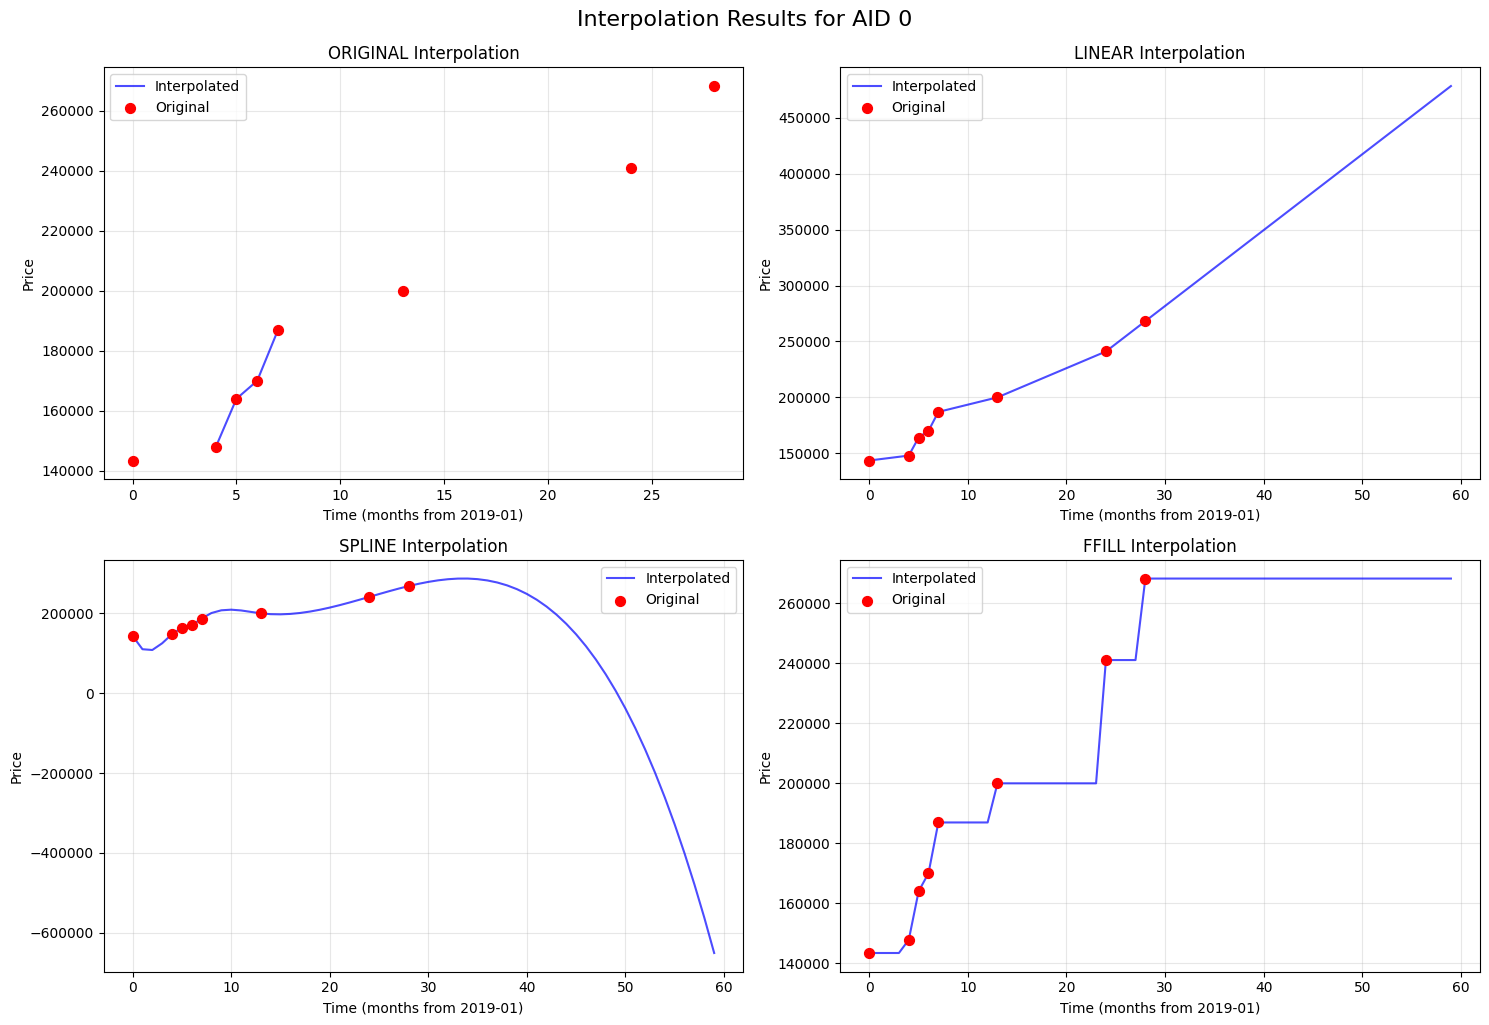


=== 보간법 성능 비교 ===
Method          RMSE       MAE        Points  
---------------------------------------------
linear          0.0000     0.0000     8       
spline          0.0000     0.0000     8       
ffill           0.0000     0.0000     8       
bfill           0.0000     0.0000     8       


In [13]:
# 완전한 데이터셋으로 테스트 (결측치가 있는 경우)
print("\n=== 완전한 데이터셋으로 보간법 테스트 (AID 0) ===")

# aid=0에 대해 완전한 데이터 생성 후 보간법 적용
test_methods_quick = ['linear', 'spline', 'ffill', 'bfill']
results_complete = apply_interpolation_methods_complete(table_merge, aid_value=0, methods=test_methods_quick)

# 결과 확인
if results_complete:
    print("\n=== 보간 결과 요약 ===")
    for method, data in results_complete.items():
        if data is not None:
            missing_count = data['price'].isna().sum()
            total_count = len(data)
            print(f"{method}: 전체 {total_count}개 중 결측치 {missing_count}개")
    
    # 시각화
    if len([k for k, v in results_complete.items() if v is not None]) > 1:
        plot_interpolation_results(results_complete, aid_value=0, max_methods=4)
        
    # 성능 평가
    if 'original' in results_complete:
        performance = evaluate_interpolation_performance(results_complete, results_complete['original'])
        
        if performance:
            print("\n=== 보간법 성능 비교 ===")
            print(f"{'Method':<15} {'RMSE':<10} {'MAE':<10} {'Points':<8}")
            print("-" * 45)
            for method, metrics in performance.items():
                print(f"{method:<15} {metrics['RMSE']:<10.4f} {metrics['MAE']:<10.4f} {metrics['num_points']:<8}")
else:
    print("No results generated")

In [14]:
# 전체 데이터에 대한 일괄 처리 함수
def process_all_apartments(data, method='linear', save_results=True):
    """
    모든 아파트에 대해 선택된 보간법을 적용
    
    Args:
        data: 전체 데이터프레임
        method: 사용할 보간법 ('linear', 'polynomial', 'spline', 'ffill', 'bfill', 'nearest', 'gp', 'neural_ode')
        save_results: 결과를 저장할지 여부
    
    Returns:
        pd.DataFrame: 보간이 완료된 데이터프레임
    """
    print(f"=== 전체 아파트 {method} 보간 처리 시작 ===")
    
    processed_data = []
    unique_aids = data['aid'].unique()
    
    method_functions = {
        'linear': linear_interpolation,
        'polynomial': polynomial_interpolation,
        'spline': spline_interpolation,
        'ffill': forward_fill,
        'bfill': backward_fill,
        'nearest': nearest_neighbor_interpolation,
        'gp': gaussian_process_interpolation,
        'neural_ode': neural_ode_interpolation
    }
    
    if method not in method_functions:
        print(f"Unknown method: {method}")
        return data
    
    interpolation_func = method_functions[method]
    
    for i, aid in enumerate(unique_aids):
        if i % 100 == 0:
            print(f"Processing {i}/{len(unique_aids)} apartments...")
        
        try:
            apartment_data = prepare_time_series_data(data, aid)
            if len(apartment_data) > 0:
                interpolated_data = interpolation_func(apartment_data)
                processed_data.append(interpolated_data)
        except Exception as e:
            print(f"Error processing aid {aid}: {str(e)}")
            # 원본 데이터 그대로 추가
            apartment_data = prepare_time_series_data(data, aid)
            if len(apartment_data) > 0:
                processed_data.append(apartment_data)
    
    # 결과 합치기
    if processed_data:
        result_df = pd.concat(processed_data, ignore_index=True)
        
        # time_numeric 컬럼 제거 (임시로 만든 것)
        if 'time_numeric' in result_df.columns:
            result_df = result_df.drop('time_numeric', axis=1)
        
        print(f"처리 완료!")
        print(f"원본 결측치: {data['price'].isna().sum()}")
        print(f"처리 후 결측치: {result_df['price'].isna().sum()}")
        
        if save_results:
            filename = f'../데이터/Table/table_merge_{method}_interpolated.csv'
            result_df.to_csv(filename, index=False)
            print(f"결과 저장: {filename}")
        
        return result_df
    else:
        print("No data processed")
        return data

# 여러 방법으로 처리하고 비교하는 함수
def compare_interpolation_methods_batch(data, methods=['linear', 'spline', 'gp'], sample_aids=None):
    """
    여러 보간법을 일괄 적용하고 결과 비교
    
    Args:
        data: 전체 데이터프레임
        methods: 비교할 방법들의 리스트
        sample_aids: 샘플링할 아파트 ID들 (None이면 전체)
    """
    if sample_aids is None:
        # 결측치가 있는 아파트들 중 일부만 샘플링
        aids_with_missing = data.groupby('aid')['price'].apply(lambda x: x.isna().any())
        sample_aids = aids_with_missing[aids_with_missing].index[:10].tolist()
    
    print(f"샘플 아파트들: {sample_aids}")
    
    all_results = {}
    
    for method in methods:
        print(f"\n=== {method} 방법 적용 중 ===")
        method_results = {}
        
        for aid in sample_aids:
            try:
                apartment_data = prepare_time_series_data(data, aid)
                if len(apartment_data) > 0 and apartment_data['price'].isna().any():
                    
                    method_functions = {
                        'linear': linear_interpolation,
                        'polynomial': polynomial_interpolation,
                        'spline': spline_interpolation,
                        'ffill': forward_fill,
                        'bfill': backward_fill,
                        'nearest': nearest_neighbor_interpolation,
                        'gp': gaussian_process_interpolation,
                        'neural_ode': neural_ode_interpolation
                    }
                    
                    if method in method_functions:
                        result = method_functions[method](apartment_data)
                        method_results[aid] = result
            except Exception as e:
                print(f"Error processing aid {aid} with {method}: {str(e)}")
        
        all_results[method] = method_results
    
    return all_results

# 업데이트된 전체 데이터에 대한 일괄 처리 함수
def process_all_apartments_complete(method='linear', save_results=True, sample_size=None):
    """
    모든 아파트에 대해 완전한 시계열을 생성하고 선택된 보간법을 적용
    
    Args:
        method: 사용할 보간법 ('linear', 'polynomial', 'spline', 'ffill', 'bfill', 'nearest', 'gp', 'neural_ode')
        save_results: 결과를 저장할지 여부
        sample_size: 테스트용으로 처리할 아파트 개수 (None이면 전체)
    
    Returns:
        pd.DataFrame: 보간이 완료된 완전한 데이터프레임
    """
    print(f"=== 완전한 데이터셋에서 {method} 보간 처리 시작 ===")
    
    # 먼저 완전한 데이터셋 생성
    print("1. 완전한 데이터셋 생성 중...")
    complete_dataset = create_complete_dataset(table_1, table_2, table_3)
    
    processed_data = []
    unique_aids = complete_dataset['aid'].unique()
    
    if sample_size is not None:
        unique_aids = unique_aids[:sample_size]
        print(f"샘플링: {len(unique_aids)}개 아파트만 처리")
    
    method_functions = {
        'linear': linear_interpolation,
        'polynomial': polynomial_interpolation,
        'spline': spline_interpolation,
        'ffill': forward_fill,
        'bfill': backward_fill,
        'nearest': nearest_neighbor_interpolation,
        'gp': gaussian_process_interpolation,
        'neural_ode': neural_ode_interpolation
    }
    
    if method not in method_functions:
        print(f"Unknown method: {method}")
        return complete_dataset
    
    interpolation_func = method_functions[method]
    
    print("2. 각 아파트별 보간 처리 중...")
    for i, aid in enumerate(unique_aids):
        if i % 50 == 0:
            print(f"Processing {i}/{len(unique_aids)} apartments...")
        
        try:
            # 해당 아파트 데이터 추출
            apartment_data = complete_dataset[complete_dataset['aid'] == aid].copy()
            apartment_data = apartment_data.sort_values(['year', 'month'])
            
            if len(apartment_data) > 0:
                # time_numeric 추가
                apartment_data['time_numeric'] = (apartment_data['year'] - 2019) * 12 + (apartment_data['month'] - 1)
                
                # 보간 적용
                interpolated_data = interpolation_func(apartment_data)
                
                # time_numeric 컬럼 제거
                if 'time_numeric' in interpolated_data.columns:
                    interpolated_data = interpolated_data.drop('time_numeric', axis=1)
                
                processed_data.append(interpolated_data)
                
        except Exception as e:
            print(f"Error processing aid {aid}: {str(e)}")
            # 원본 데이터 그대로 추가
            apartment_data = complete_dataset[complete_dataset['aid'] == aid].copy()
            if len(apartment_data) > 0:
                processed_data.append(apartment_data)
    
    # 결과 합치기
    if processed_data:
        result_df = pd.concat(processed_data, ignore_index=True)
        result_df = result_df.sort_values(['aid', 'year', 'month']).reset_index(drop=True)
        
        print(f"처리 완료!")
        print(f"원본 결측치: {complete_dataset['price'].isna().sum()}")
        print(f"처리 후 결측치: {result_df['price'].isna().sum()}")
        print(f"총 행 수: {len(result_df)}")
        
        if save_results:
            filename = f'../데이터/Table/complete_dataset_{method}_interpolated.csv'
            result_df.to_csv(filename, index=False)
            print(f"결과 저장: {filename}")
        
        return result_df
    else:
        print("No data processed")
        return complete_dataset

# 완전한 데이터셋에서 여러 방법 비교
def compare_interpolation_methods_complete(methods=['linear', 'spline'], sample_aids=None):
    """
    완전한 데이터셋에서 여러 보간법을 비교
    
    Args:
        methods: 비교할 방법들의 리스트
        sample_aids: 샘플링할 아파트 ID들 (None이면 결측치가 있는 처음 5개)
    """
    if sample_aids is None:
        # 완전한 데이터셋 생성하고 결측치가 있는 아파트들 찾기
        complete_dataset = create_complete_dataset(table_1, table_2, table_3)
        aids_with_missing = complete_dataset.groupby('aid')['price'].apply(lambda x: x.isna().any())
        sample_aids = aids_with_missing[aids_with_missing].index[:5].tolist()
    
    print(f"샘플 아파트들: {sample_aids}")
    
    all_results = {}
    
    for method in methods:
        print(f"\n=== {method} 방법 적용 중 ===")
        method_results = {}
        
        for aid in sample_aids:
            try:
                result = apply_interpolation_methods_complete(aid, methods=[method])
                if method in result and result[method] is not None:
                    method_results[aid] = result[method]
            except Exception as e:
                print(f"Error processing aid {aid} with {method}: {str(e)}")
        
        all_results[method] = method_results
    
    return all_results

=== 완전한 데이터셋을 사용한 보간법 예시 ===

1. 완전한 데이터셋 생성 테스트 (처음 5개 아파트만)

2. aid=0에 대한 완전한 보간법 적용

=== AID 0 완전한 데이터 보간 결과 ===
전체 데이터 포인트: 60
결측치 개수: 52
데이터가 있는 포인트: 8

적용 중: linear
linear 완료 - 남은 결측치: 0

적용 중: spline
spline 완료 - 남은 결측치: 0

적용 중: ffill
ffill 완료 - 남은 결측치: 0

적용 중: bfill
bfill 완료 - 남은 결측치: 31

3. 결과 시각화


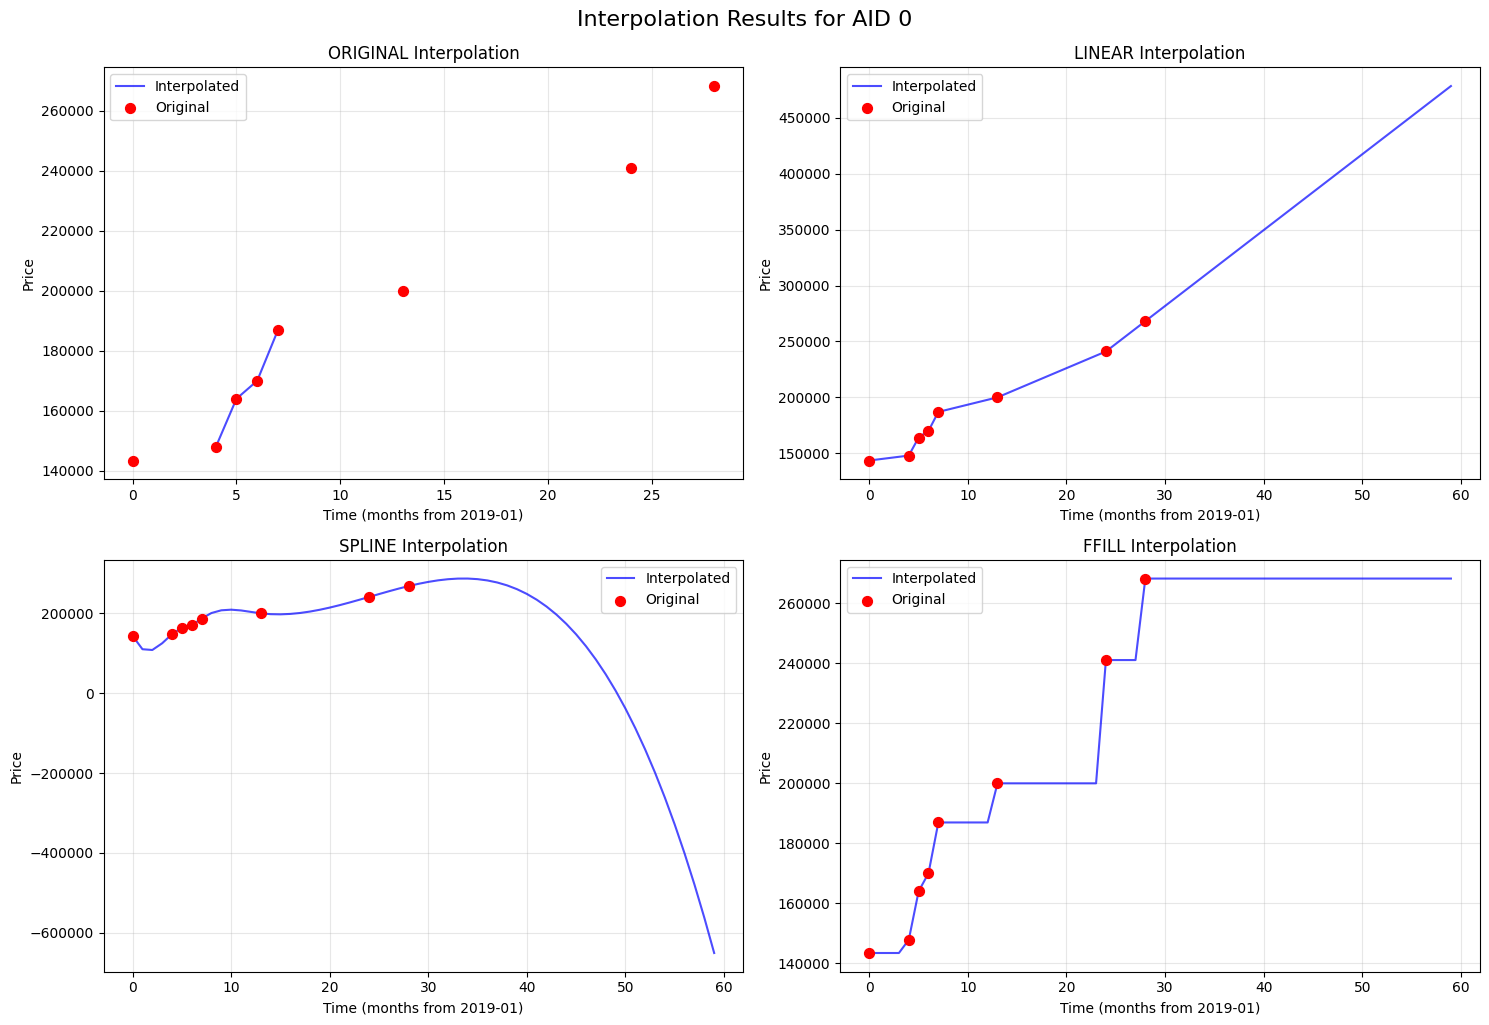


4. 성능 평가
Method          RMSE       MAE        Points  
---------------------------------------------
linear          0.0000     0.0000     8       
spline          0.0000     0.0000     8       
ffill           0.0000     0.0000     8       
bfill           0.0000     0.0000     8       

=== 완전한 데이터셋 사용법 안내 ===
1. 개별 아파트 처리:
   apply_interpolation_methods_complete(table_merge, aid_value=0, methods=['linear'])

2. 전체 데이터 처리:
   process_all_apartments_complete(method='linear', sample_size=10)

3. 여러 방법 비교:
   compare_interpolation_methods_complete(methods=['linear', 'spline'])

주의: 전체 데이터 처리는 시간이 오래 걸릴 수 있으니 먼저 sample_size를 작게 설정해서 테스트하세요!


In [15]:
# 업데이트된 사용 예시들

print("=== 완전한 데이터셋을 사용한 보간법 예시 ===")

# 1. 완전한 데이터셋 생성 (샘플)
print("\n1. 완전한 데이터셋 생성 테스트 (처음 5개 아파트만)")
# sample_complete_dataset = process_all_apartments_complete(method='linear', save_results=False, sample_size=5)

# 2. 특정 아파트에 대한 완전한 보간법 적용
print("\n2. aid=0에 대한 완전한 보간법 적용")
complete_results = apply_interpolation_methods_complete(
    table_merge,
    aid_value=0, 
    methods=['linear', 'spline', 'ffill', 'bfill']  # 빠른 방법들만
)

# 3. 결과 시각화
if complete_results and len([k for k, v in complete_results.items() if v is not None]) > 1:
    print("\n3. 결과 시각화")
    plot_interpolation_results(complete_results, 0)

# 4. 성능 평가
if complete_results and 'original' in complete_results:
    print("\n4. 성능 평가")
    performance = evaluate_interpolation_performance(complete_results, complete_results['original'])
    
    if performance:
        print(f"{'Method':<15} {'RMSE':<10} {'MAE':<10} {'Points':<8}")
        print("-" * 45)
        for method, metrics in performance.items():
            print(f"{method:<15} {metrics['RMSE']:<10.4f} {metrics['MAE']:<10.4f} {metrics['num_points']:<8}")

print("\n=== 완전한 데이터셋 사용법 안내 ===")
print("1. 개별 아파트 처리:")
print("   apply_interpolation_methods_complete(table_merge, aid_value=0, methods=['linear'])")
print("\n2. 전체 데이터 처리:")
print("   process_all_apartments_complete(method='linear', sample_size=10)")
print("\n3. 여러 방법 비교:")
print("   compare_interpolation_methods_complete(methods=['linear', 'spline'])")
print("\n주의: 전체 데이터 처리는 시간이 오래 걸릴 수 있으니 먼저 sample_size를 작게 설정해서 테스트하세요!")

## 설치 필요한 패키지

Neural ODE를 사용하려면 다음 패키지를 설치해야 합니다:

```bash
pip install torchdiffeq
```

## 보간법 설명

1. **선형 보간법 (Linear Interpolation)**: 가장 단순하고 빠른 방법. 두 점 사이를 직선으로 연결
2. **다항 보간법 (Polynomial Interpolation)**: 라그랑주 다항식을 사용. 데이터 포인트가 많으면 불안정할 수 있음
3. **스플라인 보간법 (Spline Interpolation)**: 큐빅 스플라인으로 부드러운 곡선 생성
4. **Forward Fill (ffill)**: 앞의 값으로 채우기
5. **Backward Fill (bfill)**: 뒤의 값으로 채우기  
6. **최근접 이웃 보간법**: 가장 가까운 시점의 값으로 채우기
7. **가우시안 프로세스 (GP)**: 확률적 접근, 불확실성도 함께 제공
8. **Neural ODE**: 신경망 기반 미분방정식으로 연속적인 dynamics 학습

## 사용 권장사항

- **빠른 처리가 필요한 경우**: linear, ffill, bfill
- **부드러운 곡선이 필요한 경우**: spline, gp
- **복잡한 패턴이 있는 경우**: neural_ode, gp
- **결측치가 연속적으로 많은 경우**: polynomial, spline (단, 차수 조절 필요)

### Embedding

In [22]:
epochs = 10000
lr = 1e-4
hidden_dim = 1024
sub = True # True
embedding_dim = 1024 # 1024
window_size = 12 # 12

In [23]:
# 파라미터
embedding_train_ratio = 0.7
embedding_val_ratio = 0.0
embedding_test_ratio = 0.3
embedding_batch = 64
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

embedding_lr = 0.00001
embedding_weight_decay = 0
embedding_batch = 128
embedding_epochs = 150
encoder_dim_1 = 128
encoder_dim_2 = 256
encoder_dim_3 = 512
embedding_dim = 1024
decoder_dim_1 = 512
decoder_dim_2 = 256
decoder_dim_3 = 128

embedding_window_size = 12 #????

=== Embedding 훈련 시작 ===
훈련용 파일 수: 8
테스트 파일: ../데이터/MissingValue\table_merge_2023.xlsx
테스트 데이터 로드: ../데이터/MissingValue\table_merge_2023.xlsx
테스트 데이터 크기: (2569, 19)
테스트 데이터 결측치: 0
✅ 테스트 데이터셋 크기: 2569

🔄 [1/8] bfill 방법으로 Embedding 훈련
파일: ../데이터/MissingValue\bfill_2021.xlsx
테스트 데이터 크기: (2569, 19)
테스트 데이터 결측치: 0
✅ 테스트 데이터셋 크기: 2569

🔄 [1/8] bfill 방법으로 Embedding 훈련
파일: ../데이터/MissingValue\bfill_2021.xlsx
훈련 데이터 크기: (25236, 19)
결측치 개수: 4713
✅ 데이터 준비 완료 - 훈련: 17665, 검증: 7571
훈련 데이터 크기: (25236, 19)
결측치 개수: 4713
✅ 데이터 준비 완료 - 훈련: 17665, 검증: 7571
🚀 bfill 훈련 시작...
⚠️ Epoch 1: 훈련 타겟에 NaN/Inf 발견, 건너뜀
⚠️ Epoch 1: 훈련 타겟에 NaN/Inf 발견, 건너뜀
⚠️ Epoch 1: 훈련 타겟에 NaN/Inf 발견, 건너뜀
⚠️ Epoch 1: 훈련 타겟에 NaN/Inf 발견, 건너뜀
⚠️ Epoch 1: 훈련 타겟에 NaN/Inf 발견, 건너뜀
⚠️ Epoch 1: 훈련 타겟에 NaN/Inf 발견, 건너뜀
⚠️ Epoch 1: 훈련 타겟에 NaN/Inf 발견, 건너뜀
⚠️ Epoch 1: 훈련 타겟에 NaN/Inf 발견, 건너뜀
⚠️ Epoch 1: 훈련 타겟에 NaN/Inf 발견, 건너뜀
⚠️ Epoch 1: 훈련 타겟에 NaN/Inf 발견, 건너뜀
⚠️ Epoch 1: 훈련 타겟에 NaN/Inf 발견, 건너뜀
⚠️ Epoch 1: 훈련 타겟에 NaN/Inf 발견, 건너뜀
⚠️ Epoch 1: 훈련 타겟에 Na

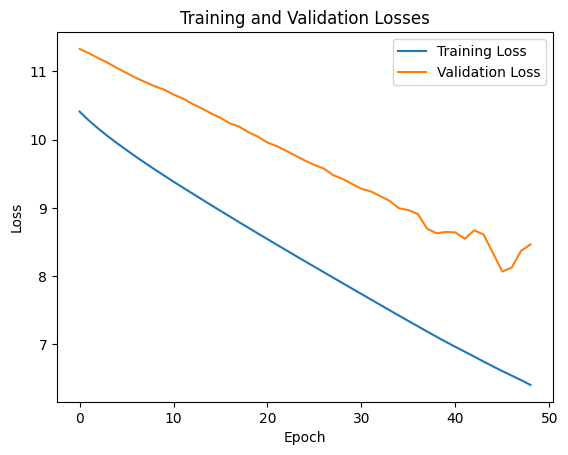


🔄 [5/8] nearest 방법으로 Embedding 훈련
파일: ../데이터/MissingValue\nearest_2021.xlsx
훈련 데이터 크기: (25236, 19)
결측치 개수: 1188
✅ 데이터 준비 완료 - 훈련: 17665, 검증: 7571
🚀 nearest 훈련 시작...
훈련 데이터 크기: (25236, 19)
결측치 개수: 1188
✅ 데이터 준비 완료 - 훈련: 17665, 검증: 7571
🚀 nearest 훈련 시작...
⚠️ Epoch 1: 훈련 타겟에 NaN/Inf 발견, 건너뜀
⚠️ Epoch 1: 훈련 타겟에 NaN/Inf 발견, 건너뜀
⚠️ Epoch 1: 훈련 타겟에 NaN/Inf 발견, 건너뜀
⚠️ Epoch 1: 훈련 타겟에 NaN/Inf 발견, 건너뜀
⚠️ Epoch 1: 훈련 타겟에 NaN/Inf 발견, 건너뜀
⚠️ Epoch 1: 훈련 타겟에 NaN/Inf 발견, 건너뜀
⚠️ Epoch 1: 훈련 타겟에 NaN/Inf 발견, 건너뜀
⚠️ Epoch 1: 훈련 타겟에 NaN/Inf 발견, 건너뜀
⚠️ Epoch 1: 훈련 타겟에 NaN/Inf 발견, 건너뜀
⚠️ Epoch 1: 훈련 타겟에 NaN/Inf 발견, 건너뜀
⚠️ Epoch 1: 훈련 타겟에 NaN/Inf 발견, 건너뜀
⚠️ Epoch 1: 훈련 타겟에 NaN/Inf 발견, 건너뜀
⚠️ Epoch 1: 훈련 타겟에 NaN/Inf 발견, 건너뜀
⚠️ Epoch 1: 훈련 타겟에 NaN/Inf 발견, 건너뜀
⚠️ Epoch 1: 훈련 타겟에 NaN/Inf 발견, 건너뜀
⚠️ Epoch 1: 훈련 타겟에 NaN/Inf 발견, 건너뜀
⚠️ Epoch 1: 훈련 타겟에 NaN/Inf 발견, 건너뜀
⚠️ Epoch 1: 훈련 타겟에 NaN/Inf 발견, 건너뜀
⚠️ Epoch 1: 훈련 타겟에 NaN/Inf 발견, 건너뜀
⚠️ Epoch 1: 훈련 타겟에 NaN/Inf 발견, 건너뜀
⚠️ Epoch 1: 훈련 타겟에 NaN/Inf 발견, 건너뜀
⚠️ Epoch 1

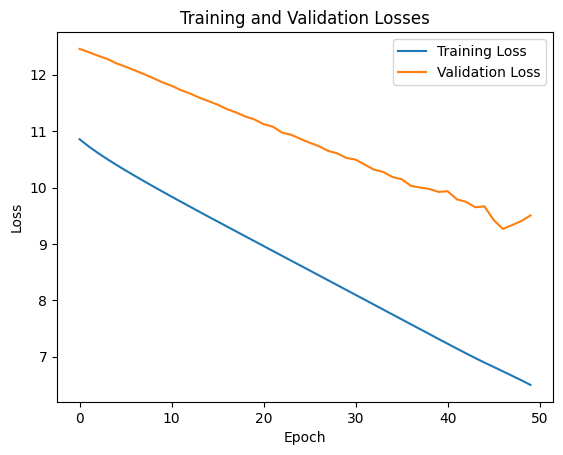


🔄 [6/8] polynomial 방법으로 Embedding 훈련
파일: ../데이터/MissingValue\polynomial_2021.xlsx
훈련 데이터 크기: (25236, 19)
결측치 개수: 1888
✅ 데이터 준비 완료 - 훈련: 17665, 검증: 7571
🚀 polynomial 훈련 시작...
⚠️ Epoch 1: 훈련 타겟에 NaN/Inf 발견, 건너뜀
훈련 데이터 크기: (25236, 19)
결측치 개수: 1888
✅ 데이터 준비 완료 - 훈련: 17665, 검증: 7571
🚀 polynomial 훈련 시작...
⚠️ Epoch 1: 훈련 타겟에 NaN/Inf 발견, 건너뜀
⚠️ Epoch 1: 훈련 타겟에 NaN/Inf 발견, 건너뜀
⚠️ Epoch 1: 훈련 타겟에 NaN/Inf 발견, 건너뜀
⚠️ Epoch 1: 훈련 타겟에 NaN/Inf 발견, 건너뜀
⚠️ Epoch 1: 훈련 타겟에 NaN/Inf 발견, 건너뜀
⚠️ Epoch 1: 훈련 타겟에 NaN/Inf 발견, 건너뜀
⚠️ Epoch 1: 훈련 타겟에 NaN/Inf 발견, 건너뜀
⚠️ Epoch 1: 훈련 타겟에 NaN/Inf 발견, 건너뜀
⚠️ Epoch 1: 훈련 타겟에 NaN/Inf 발견, 건너뜀
⚠️ Epoch 1: 훈련 타겟에 NaN/Inf 발견, 건너뜀
⚠️ Epoch 1: 훈련 타겟에 NaN/Inf 발견, 건너뜀
⚠️ Epoch 1: 훈련 타겟에 NaN/Inf 발견, 건너뜀
⚠️ Epoch 1: 훈련 타겟에 NaN/Inf 발견, 건너뜀
⚠️ Epoch 1: 훈련 타겟에 NaN/Inf 발견, 건너뜀
⚠️ Epoch 1: 훈련 타겟에 NaN/Inf 발견, 건너뜀
⚠️ Epoch 1: 훈련 타겟에 NaN/Inf 발견, 건너뜀
⚠️ Epoch 1: 훈련 타겟에 NaN/Inf 발견, 건너뜀
⚠️ Epoch 1: 훈련 타겟에 NaN/Inf 발견, 건너뜀
⚠️ Epoch 1: 훈련 타겟에 NaN/Inf 발견, 건너뜀
⚠️ Epoch 1: 훈련 타겟에 NaN/Inf 발견, 건너

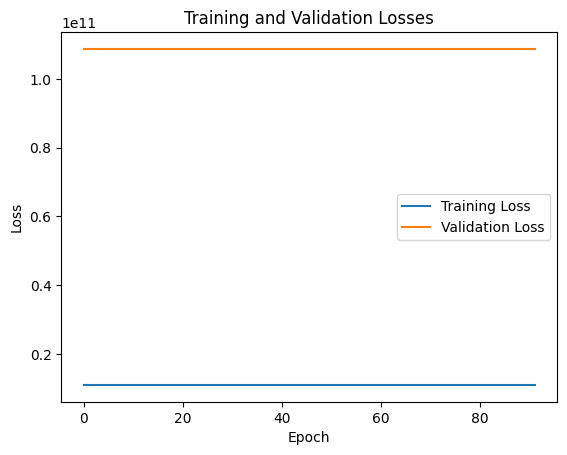


🔄 [7/8] spline 방법으로 Embedding 훈련
파일: ../데이터/MissingValue\spline_2021.xlsx
훈련 데이터 크기: (25236, 19)
결측치 개수: 1888
✅ 데이터 준비 완료 - 훈련: 17665, 검증: 7571
🚀 spline 훈련 시작...
⚠️ Epoch 1: 훈련 타겟에 NaN/Inf 발견, 건너뜀
훈련 데이터 크기: (25236, 19)
결측치 개수: 1888
✅ 데이터 준비 완료 - 훈련: 17665, 검증: 7571
🚀 spline 훈련 시작...
⚠️ Epoch 1: 훈련 타겟에 NaN/Inf 발견, 건너뜀
⚠️ Epoch 1: 훈련 타겟에 NaN/Inf 발견, 건너뜀
⚠️ Epoch 1: 훈련 타겟에 NaN/Inf 발견, 건너뜀
⚠️ Epoch 1: 훈련 타겟에 NaN/Inf 발견, 건너뜀
⚠️ Epoch 1: 훈련 타겟에 NaN/Inf 발견, 건너뜀
⚠️ Epoch 1: 훈련 타겟에 NaN/Inf 발견, 건너뜀
⚠️ Epoch 1: 훈련 타겟에 NaN/Inf 발견, 건너뜀
⚠️ Epoch 1: 훈련 타겟에 NaN/Inf 발견, 건너뜀
⚠️ Epoch 1: 훈련 타겟에 NaN/Inf 발견, 건너뜀
⚠️ Epoch 1: 훈련 타겟에 NaN/Inf 발견, 건너뜀
⚠️ Epoch 1: 훈련 타겟에 NaN/Inf 발견, 건너뜀
⚠️ Epoch 1: 훈련 타겟에 NaN/Inf 발견, 건너뜀
⚠️ Epoch 1: 훈련 타겟에 NaN/Inf 발견, 건너뜀
⚠️ Epoch 1: 훈련 타겟에 NaN/Inf 발견, 건너뜀
⚠️ Epoch 1: 훈련 타겟에 NaN/Inf 발견, 건너뜀
⚠️ Epoch 1: 훈련 타겟에 NaN/Inf 발견, 건너뜀
⚠️ Epoch 1: 훈련 타겟에 NaN/Inf 발견, 건너뜀
⚠️ Epoch 1: 훈련 타겟에 NaN/Inf 발견, 건너뜀
⚠️ Epoch 1: 훈련 타겟에 NaN/Inf 발견, 건너뜀
⚠️ Epoch 1: 훈련 타겟에 NaN/Inf 발견, 건너뜀
⚠️ Epoch 1: 훈련

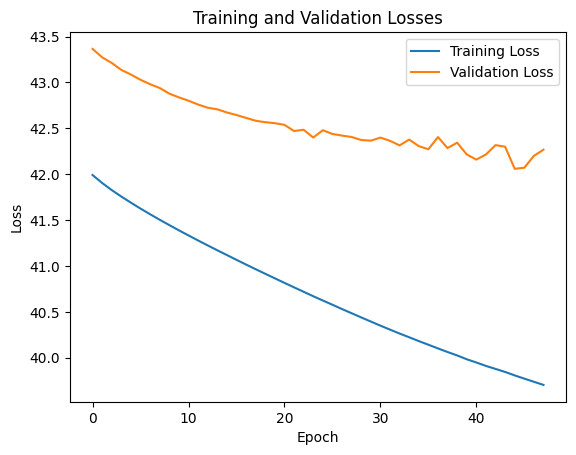


🔄 [8/8] table_merge 방법으로 Embedding 훈련
파일: ../데이터/MissingValue\table_merge_2021.xlsx
훈련 데이터 크기: (57800, 19)
결측치 개수: 0
✅ 데이터 준비 완료 - 훈련: 40460, 검증: 17340
🚀 table_merge 훈련 시작...
훈련 데이터 크기: (57800, 19)
결측치 개수: 0
✅ 데이터 준비 완료 - 훈련: 40460, 검증: 17340
🚀 table_merge 훈련 시작...
Epoch [1/150], Train Loss: 4.961905, Val Loss: 9.034721
Epoch [1/150], Train Loss: 4.961905, Val Loss: 9.034721
Epoch [10/150], Train Loss: 2.757991, Val Loss: 7.366921
Epoch [10/150], Train Loss: 2.757991, Val Loss: 7.366921
Epoch [20/150], Train Loss: 1.075812, Val Loss: 5.832965
Epoch [20/150], Train Loss: 1.075812, Val Loss: 5.832965
Epoch [30/150], Train Loss: 0.534790, Val Loss: 4.992555
Epoch [30/150], Train Loss: 0.534790, Val Loss: 4.992555
Epoch [40/150], Train Loss: 0.483615, Val Loss: 4.808389
Epoch [40/150], Train Loss: 0.483615, Val Loss: 4.808389
Epoch [50/150], Train Loss: 0.443681, Val Loss: 4.708311
Epoch [50/150], Train Loss: 0.443681, Val Loss: 4.708311
Epoch [60/150], Train Loss: 0.407097, Val Loss: 4.6

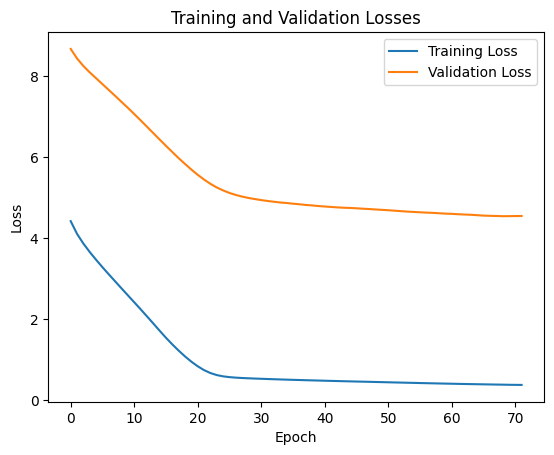


📋 전체 결과 정리

🏆 Embedding 결과 요약 (Val Loss 기준 정렬):
     Method  Best_Epoch  Best_Val_Loss  Test_Loss
table_merge          70   4.541987e+00   9.303299
     linear          47   8.066902e+00   6.658679
    nearest          48   9.266335e+00   7.490625
     spline          46   4.205887e+01  10.336520
 polynomial          90   1.087557e+11  13.948372

💾 결과 저장됨: ../데이터/MissingValue/embedding_results_summary.xlsx

🎯 최고 성능 방법: table_merge
   📈 Best Epoch: 70
   📊 Best Val Loss: 4.541987
   🎯 Test Loss: 9.303299

🎉 모든 Embedding 처리 완료!


In [24]:
# MissingValue 폴더의 모든 보간 데이터로 Embedding 훈련 및 평가
import os
import glob
import pandas as pd
import copy
import numpy as np

# 결과를 저장할 리스트
embedding_results = []

# MissingValue 폴더에서 훈련용 파일들 찾기 (2021 데이터)
missing_value_dir = "../데이터/MissingValue"
train_files = glob.glob(os.path.join(missing_value_dir, "*_2021.xlsx"))
test_file = os.path.join(missing_value_dir, "table_merge_2023.xlsx")

print(f"=== Embedding 훈련 시작 ===")
print(f"훈련용 파일 수: {len(train_files)}")
print(f"테스트 파일: {test_file}")

# 테스트 데이터 로드 (한 번만)
test_dataloader = None
if os.path.exists(test_file):
    print(f"테스트 데이터 로드: {test_file}")
    test_data = pd.read_excel(test_file)
    print(f"테스트 데이터 크기: {test_data.shape}")
    print(f"테스트 데이터 결측치: {test_data['price'].isna().sum()}")
    
    # 테스트 데이터 검증
    if test_data['price'].isna().all():
        print("⚠️ 테스트 데이터의 모든 price가 결측치입니다.")
        test_dataloader = None
    else:
        try:
            # 테스트 데이터셋 생성
            test_dataset = Embedding_Dataset(test_data, DEVICE)
            if len(test_dataset) > 0:
                test_dataloader = DataLoader(test_dataset, batch_size=embedding_batch, shuffle=False, drop_last=True)
                print(f"✅ 테스트 데이터셋 크기: {len(test_dataset)}")
            else:
                test_dataloader = None
                print("❌ 테스트 데이터셋이 비어있음")
        except Exception as e:
            print(f"❌ 테스트 데이터셋 생성 실패: {str(e)}")
            test_dataloader = None
else:
    print(f"❌ 테스트 파일이 없습니다: {test_file}")

# 각 훈련 파일에 대해 embedding 수행
for file_idx, train_file in enumerate(train_files):
    # 파일명에서 방법 추출
    method_name = os.path.basename(train_file).replace("_2021.xlsx", "")
    print(f"\n{'='*60}")
    print(f"🔄 [{file_idx+1}/{len(train_files)}] {method_name} 방법으로 Embedding 훈련")
    print(f"파일: {train_file}")
    print(f"{'='*60}")
    
    try:
        # 훈련 데이터 로드
        table_merge = pd.read_excel(train_file, engine='openpyxl')
        print(f"훈련 데이터 크기: {table_merge.shape}")
        print(f"결측치 개수: {table_merge['price'].isna().sum()}")
        
        # 데이터 검증
        if table_merge.empty:
            print(f"❌ {method_name}: 데이터가 비어있음")
            continue
            
        if table_merge['price'].isna().all():
            print(f"❌ {method_name}: 모든 price가 결측치")
            continue
        
        # 무한값이나 비정상적인 값 체크
        if np.isinf(table_merge['price']).any():
            print(f"⚠️ {method_name}: price에 무한값 발견, 제거 중...")
            table_merge = table_merge[~np.isinf(table_merge['price'])]
            
        if np.isnan(table_merge['price']).all():
            print(f"❌ {method_name}: 무한값 제거 후 모든 데이터가 결측치")
            continue
        
        # 데이터셋 생성
        dataset = Embedding_Dataset(table_merge, DEVICE)
        
        if len(dataset) == 0:
            print(f"❌ {method_name}: 데이터셋이 비어있음")
            continue
            
        dataset_length = len(dataset)
        split_point = int(embedding_train_ratio * len(dataset))
        
        if split_point == 0 or split_point == dataset_length:
            print(f"❌ {method_name}: 데이터 분할 오류 (split_point: {split_point}, total: {dataset_length})")
            continue
            
        train_indices = range(0, split_point)
        val_indices = range(split_point, dataset_length)

        train_dataset = Subset(dataset, train_indices)
        val_dataset = Subset(dataset, val_indices)

        train_dataloader = DataLoader(train_dataset, batch_size=embedding_batch, shuffle=False, drop_last=True)
        val_dataloader = DataLoader(val_dataset, batch_size=embedding_batch, shuffle=False, drop_last=True)
        
        if len(train_dataloader) == 0 or len(val_dataloader) == 0:
            print(f"❌ {method_name}: DataLoader가 비어있음 (train: {len(train_dataloader)}, val: {len(val_dataloader)})")
            continue
        
        print(f"✅ 데이터 준비 완료 - 훈련: {len(train_dataset)}, 검증: {len(val_dataset)}")
        
        # 모델 초기화
        model = Embedding(encoder_dim_1, encoder_dim_2, encoder_dim_3, embedding_dim, 
                         decoder_dim_1, decoder_dim_2, decoder_dim_3).to(DEVICE)
        criterion = RMSE()
        optimizer = torch.optim.Adam(model.parameters(), lr=embedding_lr, weight_decay=embedding_weight_decay)

        train_losses = []
        val_losses = []
        best_val_loss = float('inf')
        best_epoch = 0
        best_model_state = None
        consecutive_val_loss_increases = 0
        max_consecutive_val_loss_increases = 3

        print(f"🚀 {method_name} 훈련 시작...")
        
        for epoch in range(embedding_epochs):
            # 훈련 단계
            model.train()
            total_train_loss = 0
            train_batch_count = 0
            
            for data in train_dataloader:
                input = data[0].to(DEVICE)
                target = data[1].to(DEVICE)
                
                # 입력 데이터 검증
                if torch.isnan(input).any() or torch.isinf(input).any():
                    print(f"⚠️ Epoch {epoch+1}: 훈련 입력에 NaN/Inf 발견, 건너뜀")
                    continue
                if torch.isnan(target).any() or torch.isinf(target).any():
                    print(f"⚠️ Epoch {epoch+1}: 훈련 타겟에 NaN/Inf 발견, 건너뜀")
                    continue
                
                output = model(input).to(DEVICE)
                
                # 출력 검증
                if torch.isnan(output).any() or torch.isinf(output).any():
                    print(f"⚠️ Epoch {epoch+1}: 모델 출력에 NaN/Inf 발견")
                    break

                train_loss = criterion(output, target)
                
                # Loss 검증
                if torch.isnan(train_loss) or torch.isinf(train_loss):
                    print(f"⚠️ Epoch {epoch+1}: 훈련 loss가 NaN/Inf")
                    break
                
                total_train_loss += train_loss.item()
                train_batch_count += 1

                optimizer.zero_grad()
                train_loss.backward()
                
                # 그래디언트 클리핑
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                
                optimizer.step()

            if train_batch_count == 0:
                print(f"❌ Epoch {epoch+1}: 유효한 훈련 배치가 없음")
                break
                
            avg_train_loss = total_train_loss / train_batch_count
            
            if np.isnan(avg_train_loss) or np.isinf(avg_train_loss):
                print(f"❌ Epoch {epoch+1}: 평균 훈련 loss가 NaN/Inf ({avg_train_loss})")
                break
                
            train_losses.append(avg_train_loss)

            # 검증 단계
            model.eval()
            total_val_loss = 0
            val_batch_count = 0
            
            with torch.no_grad():
                for data in val_dataloader:
                    input = data[0].to(DEVICE)
                    target = data[1].to(DEVICE)
                    
                    # 입력 데이터 검증
                    if torch.isnan(input).any() or torch.isinf(input).any():
                        continue
                    if torch.isnan(target).any() or torch.isinf(target).any():
                        continue
                    
                    output = model(input).to(DEVICE)
                    
                    if torch.isnan(output).any() or torch.isinf(output).any():
                        continue

                    val_loss = criterion(output, target)
                    
                    if torch.isnan(val_loss) or torch.isinf(val_loss):
                        continue
                        
                    total_val_loss += val_loss.item()
                    val_batch_count += 1

            if val_batch_count == 0:
                print(f"❌ Epoch {epoch+1}: 유효한 검증 배치가 없음")
                break
                
            avg_val_loss = total_val_loss / val_batch_count
            
            if np.isnan(avg_val_loss) or np.isinf(avg_val_loss):
                print(f"❌ Epoch {epoch+1}: 평균 검증 loss가 NaN/Inf ({avg_val_loss})")
                break
                
            val_losses.append(avg_val_loss)
            
            # 최고 성능 기록
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                best_epoch = epoch + 1
                best_model_state = copy.deepcopy(model.state_dict())

            early_stop, consecutive_val_loss_increases = early_stops(val_losses, consecutive_val_loss_increases, max_consecutive_val_loss_increases)
            
            if early_stop:
                print(f'Epoch [{epoch+1}/{embedding_epochs}], Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}')
                print(f'✋ Early Stop Triggered!')
                break

            if (epoch + 1) % 10 == 0 or epoch == 0:
                print(f'Epoch [{epoch+1}/{embedding_epochs}], Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}')

        if not train_losses or not val_losses:
            print(f"❌ {method_name}: 훈련이 제대로 진행되지 않음")
            continue
            
        print(f"✅ {method_name} 훈련 완료!")
        print(f"   Best Epoch: {best_epoch}, Best Val Loss: {best_val_loss:.6f}")
        
        # 최고 모델로 테스트 데이터 평가
        avg_test_loss = float('nan')
        if test_dataloader is not None and best_model_state is not None:
            print(f"📊 {method_name} 테스트 데이터 평가 중...")
            
            try:
                # 최고 모델 로드
                model.load_state_dict(best_model_state)
                
                model.eval()
                total_test_loss = 0
                test_batch_count = 0
                
                with torch.no_grad():
                    for data in test_dataloader:
                        input = data[0].to(DEVICE)
                        target = data[1].to(DEVICE)
                        
                        if torch.isnan(input).any() or torch.isinf(input).any():
                            continue
                        if torch.isnan(target).any() or torch.isinf(target).any():
                            continue
                        
                        output = model(input).to(DEVICE)
                        
                        if torch.isnan(output).any() or torch.isinf(output).any():
                            continue

                        test_loss = criterion(output, target)
                        
                        if torch.isnan(test_loss) or torch.isinf(test_loss):
                            continue
                            
                        total_test_loss += test_loss.item()
                        test_batch_count += 1

                if test_batch_count > 0:
                    avg_test_loss = total_test_loss / test_batch_count
                    print(f"   Test Loss: {avg_test_loss:.6f}")
                else:
                    print(f"   ⚠️ 유효한 테스트 배치가 없음")
                    
            except Exception as e:
                print(f"   ❌ 테스트 평가 실패: {str(e)}")
        
        # 최고 모델 저장
        if best_model_state is not None:
            model_save_path = f'../데이터/Checkpoint/embedding/default/{method_name}_best_model.pth'
            torch.save(best_model_state, model_save_path)
            print(f"   💾 모델 저장: {model_save_path}")
        
        # 결과 저장
        result = {
            'Method': method_name,
            'File_Name': os.path.basename(train_file),
            'Best_Epoch': best_epoch,
            'Best_Val_Loss': round(best_val_loss, 6) if not (np.isnan(best_val_loss) or np.isinf(best_val_loss)) else 'Invalid',
            'Final_Train_Loss': round(train_losses[-1], 6) if train_losses and not (np.isnan(train_losses[-1]) or np.isinf(train_losses[-1])) else 'Invalid',
            'Test_Loss': round(avg_test_loss, 6) if not (pd.isna(avg_test_loss) or np.isinf(avg_test_loss)) else 'N/A',
            'Total_Epochs': len(train_losses),
            'Train_Data_Size': len(train_dataset),
            'Val_Data_Size': len(val_dataset),
            'Test_Data_Size': len(test_dataset) if test_dataloader is not None else 0
        }
        
        embedding_results.append(result)
        
        # 이 방법의 그래프 그리기
        if train_losses and val_losses:
            try:
                print(f"📊 {method_name} 학습 곡선 그래프 생성")
                plot_train_val_losses(train_losses, val_losses)
            except Exception as e:
                print(f"⚠️ 그래프 생성 실패: {str(e)}")
        
    except Exception as e:
        print(f"❌ {method_name} 처리 중 오류: {str(e)}")
        import traceback
        traceback.print_exc()
        
        # 오류 결과도 기록
        error_result = {
            'Method': method_name,
            'File_Name': os.path.basename(train_file),
            'Best_Epoch': 'Error',
            'Best_Val_Loss': 'Error', 
            'Final_Train_Loss': 'Error',
            'Test_Loss': 'Error',
            'Total_Epochs': 'Error',
            'Train_Data_Size': 'Error',
            'Val_Data_Size': 'Error',
            'Test_Data_Size': 'Error'
        }
        embedding_results.append(error_result)
            
        dataset_length = len(dataset)
        split_point = int(embedding_train_ratio * len(dataset))
        train_indices = range(0, split_point)
        val_indices = range(split_point, dataset_length)

        train_dataset = Subset(dataset, train_indices)
        val_dataset = Subset(dataset, val_indices)

        train_dataloader = DataLoader(train_dataset, batch_size=embedding_batch, shuffle=False, drop_last=True)
        val_dataloader = DataLoader(val_dataset, batch_size=embedding_batch, shuffle=False, drop_last=True)
        
        print(f"훈련 데이터: {len(train_dataset)}, 검증 데이터: {len(val_dataset)}")
        
        # 모델 초기화
        model = Embedding(encoder_dim_1, encoder_dim_2, encoder_dim_3, embedding_dim, 
                         decoder_dim_1, decoder_dim_2, decoder_dim_3).to(DEVICE)
        criterion = RMSE()
        optimizer = torch.optim.Adam(model.parameters(), lr=embedding_lr, weight_decay=embedding_weight_decay)

        train_losses = []
        val_losses = []
        best_val_loss = float('inf')
        best_epoch = 0
        best_model_state = None
        consecutive_val_loss_increases = 0
        max_consecutive_val_loss_increases = 3

        print(f"🚀 {method_name} 훈련 시작...")
        
        for epoch in range(embedding_epochs):
            model.train()
            total_train_loss = 0
            for data in train_dataloader:
                input = data[0].to(DEVICE)
                target = data[1].to(DEVICE)
                output = model(input).to(DEVICE)

                train_loss = criterion(output, target)
                total_train_loss += train_loss.item()

                optimizer.zero_grad()
                train_loss.backward()
                optimizer.step()

            avg_train_loss = total_train_loss / len(train_dataloader)
            train_losses.append(avg_train_loss)

            model.eval()
            total_val_loss = 0
            with torch.no_grad():
                for data in val_dataloader:
                    input = data[0].to(DEVICE)
                    target = data[1].to(DEVICE)
                    output = model(input).to(DEVICE)

                    val_loss = criterion(output, target)
                    total_val_loss += val_loss.item()

            avg_val_loss = total_val_loss / len(val_dataloader)
            val_losses.append(avg_val_loss)
            
            # 최고 성능 기록
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                best_epoch = epoch + 1
                best_model_state = copy.deepcopy(model.state_dict())

            early_stop, consecutive_val_loss_increases = early_stops(val_losses, consecutive_val_loss_increases, max_consecutive_val_loss_increases)
            
            if early_stop:
                print(f'Epoch [{epoch+1}/{embedding_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')
                print(f'✋ Early Stop Triggered!')
                break

            if (epoch + 1) % 10 == 0 or epoch == 0:
                print(f'Epoch [{epoch+1}/{embedding_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

        print(f"✅ {method_name} 훈련 완료!")
        print(f"   Best Epoch: {best_epoch}, Best Val Loss: {best_val_loss:.6f}")
        
        # 최고 모델로 테스트 데이터 평가
        avg_test_loss = float('nan')
        if test_dataloader is not None and best_model_state is not None:
            print(f"📊 {method_name} 테스트 데이터 평가 중...")
            
            # 최고 모델 로드
            model.load_state_dict(best_model_state)
            
            model.eval()
            total_test_loss = 0
            with torch.no_grad():
                for data in test_dataloader:
                    input = data[0].to(DEVICE)
                    target = data[1].to(DEVICE)
                    output = model(input).to(DEVICE)

                    test_loss = criterion(output, target)
                    total_test_loss += test_loss.item()

            avg_test_loss = total_test_loss / len(test_dataloader)
            print(f"   Test Loss: {avg_test_loss:.6f}")
        
        # 최고 모델 저장
        if best_model_state is not None:
            model_save_path = f'../데이터/Checkpoint/embedding/default/{method_name}_best_model.pth'
            torch.save(best_model_state, model_save_path)
            print(f"   모델 저장: {model_save_path}")
        
        # 결과 저장
        result = {
            'Method': method_name,
            'File_Name': os.path.basename(train_file),
            'Best_Epoch': best_epoch,
            'Best_Val_Loss': round(best_val_loss, 6),
            'Final_Train_Loss': round(train_losses[-1], 6) if train_losses else float('nan'),
            'Test_Loss': round(avg_test_loss, 6) if not pd.isna(avg_test_loss) else 'N/A',
            'Total_Epochs': len(train_losses),
            'Train_Data_Size': len(train_dataset),
            'Val_Data_Size': len(val_dataset),
            'Test_Data_Size': len(test_dataset) if test_dataloader is not None else 0
        }
        
        embedding_results.append(result)
        
        # 이 방법의 그래프 그리기
        if train_losses and val_losses:
            print(f"📊 {method_name} 학습 곡선 그래프 생성")
            plot_train_val_losses(train_losses, val_losses)
        
    except Exception as e:
        print(f"❌ {method_name} 처리 중 오류: {str(e)}")
        import traceback
        traceback.print_exc()
        
        # 오류 결과도 기록
        error_result = {
            'Method': method_name,
            'File_Name': os.path.basename(train_file),
            'Best_Epoch': 'Error',
            'Best_Val_Loss': 'Error', 
            'Final_Train_Loss': 'Error',
            'Test_Loss': 'Error',
            'Total_Epochs': 'Error',
            'Train_Data_Size': 'Error',
            'Val_Data_Size': 'Error',
            'Test_Data_Size': 'Error'
        }
        embedding_results.append(error_result)

# 결과를 DataFrame으로 변환하고 저장
print(f"\n{'='*60}")
print(f"📋 전체 결과 정리")
print(f"{'='*60}")

if embedding_results:
    results_df = pd.DataFrame(embedding_results)
    
    # 숫자형 데이터만 정렬 (에러가 아닌 것들)
    numeric_results = results_df[results_df['Best_Val_Loss'] != 'Error'].copy()
    if not numeric_results.empty:
        numeric_results['Best_Val_Loss'] = pd.to_numeric(numeric_results['Best_Val_Loss'])
        numeric_results = numeric_results.sort_values('Best_Val_Loss').reset_index(drop=True)
        
        print("\n🏆 Embedding 결과 요약 (Val Loss 기준 정렬):")
        print(numeric_results[['Method', 'Best_Epoch', 'Best_Val_Loss', 'Test_Loss']].to_string(index=False))
        
        # 엑셀 파일로 저장
        results_file = "../데이터/MissingValue/embedding_results_summary.xlsx"
        results_df.to_excel(results_file, index=False, engine='openpyxl')
        print(f"\n💾 결과 저장됨: {results_file}")
        
        # 최고 성능 방법 출력
        best_method = numeric_results.iloc[0]
        print(f"\n🎯 최고 성능 방법: {best_method['Method']}")
        print(f"   📈 Best Epoch: {best_method['Best_Epoch']}")
        print(f"   📊 Best Val Loss: {best_method['Best_Val_Loss']:.6f}")
        print(f"   🎯 Test Loss: {best_method['Test_Loss']}")
        
    else:
        print("❌ 성공적으로 처리된 결과가 없습니다.")
        
else:
    print("❌ 처리할 파일이 없거나 모든 처리가 실패했습니다.")

print(f"\n{'='*60}")
print(f"🎉 모든 Embedding 처리 완료!")
print(f"{'='*60}")

In [25]:
# GP (Gaussian Process) 보간법 테스트
print("🤖 Gaussian Process 보간법 테스트")
print("="*50)

from Filling_missing import gaussian_process_interpolation

# 기존 데이터로 GP 테스트
if 'aid_0_data' in locals():
    print(f"📊 AID 0 데이터로 GP 보간 테스트")
    print(f"  - 전체 데이터 포인트: {len(aid_0_data)}")
    print(f"  - 결측치 개수: {aid_0_data['price'].isna().sum()}")
    
    # 의도적으로 결측치 만들기 (테스트용)
    test_data = aid_0_data.copy()
    # 5개 포인트를 결측치로 만들기
    random_indices = np.random.choice(test_data.index, 5, replace=False)
    test_data.loc[random_indices, 'price'] = np.nan
    
    print(f"\n🔧 테스트를 위해 {len(random_indices)}개 포인트를 결측치로 변경")
    print(f"  - 결측치 포인트: {random_indices.tolist()}")
    
    # 다양한 GP 설정으로 테스트
    gp_configs = [
        {'length_scale': 1.0, 'noise_level': 0.1, 'name': '기본 설정'},
        {'length_scale': 0.5, 'noise_level': 0.05, 'name': '세밀한 추적 (작은 length_scale)'},
        {'length_scale': 2.0, 'noise_level': 0.2, 'name': '부드러운 추적 (큰 length_scale)'},
        {'length_scale': 5.0, 'noise_level': 0.1, 'name': '매우 부드러운 추적'}
    ]
    
    gp_results = {}
    
    for config in gp_configs:
        print(f"\n🔬 [{config['name']}] 테스트:")
        print(f"   length_scale={config['length_scale']}, noise_level={config['noise_level']}")
        
        try:
            gp_result = gaussian_process_interpolation(test_data.copy(), 
                                                     length_scale=config['length_scale'], 
                                                     noise_level=config['noise_level'])
            
            # 결과 저장
            gp_results[config['name']] = gp_result
            
            print(f"   ✅ 성공: 결측치 {gp_result['price'].isna().sum()}개")
            
            # 원본과 비교 (결측치로 만든 부분)
            original_values = aid_0_data.loc[random_indices, 'price'].values
            predicted_values = gp_result.loc[random_indices, 'price'].values
            
            mse = np.mean((original_values - predicted_values)**2)
            mae = np.mean(np.abs(original_values - predicted_values))
            
            print(f"   📊 예측 성능 (결측치로 만든 부분):")
            print(f"      MSE: {mse:.6f}")
            print(f"      MAE: {mae:.6f}")
            
        except Exception as e:
            print(f"   ❌ 실패: {str(e)}")
            gp_results[config['name']] = None
    
    # 최고 성능 설정 찾기
    print(f"\n🏆 GP 설정별 성능 비교:")
    best_config = None
    best_mae = float('inf')
    
    for config_name, result in gp_results.items():
        if result is not None:
            original_values = aid_0_data.loc[random_indices, 'price'].values
            predicted_values = result.loc[random_indices, 'price'].values
            mae = np.mean(np.abs(original_values - predicted_values))
            
            print(f"   {config_name}: MAE = {mae:.6f}")
            
            if mae < best_mae:
                best_mae = mae
                best_config = config_name
    
    if best_config:
        print(f"\n🎯 최고 성능: {best_config} (MAE: {best_mae:.6f})")
    
else:
    print("❌ 테스트용 데이터 (aid_0_data)가 없습니다.")
    
    # 대신 간단한 예제 데이터로 테스트
    print("\n🔄 예제 데이터로 GP 테스트:")
    
    # 예제 데이터 생성
    np.random.seed(42)
    time_points = np.linspace(0, 10, 20)
    # 사인파 + 노이즈
    true_prices = 100 + 20 * np.sin(time_points) + np.random.normal(0, 2, len(time_points))
    
    # 일부를 결측치로 만들기
    missing_indices = [3, 7, 11, 15, 18]
    prices_with_missing = true_prices.copy()
    prices_with_missing[missing_indices] = np.nan
    
    example_data = pd.DataFrame({
        'time_numeric': time_points,
        'price': prices_with_missing
    })
    
    print(f"📊 예제 데이터:")
    print(f"  - 전체 포인트: {len(example_data)}")
    print(f"  - 결측치: {len(missing_indices)}개")
    
    # GP 보간 수행
    print(f"\n🤖 GP 보간 수행:")
    gp_result = gaussian_process_interpolation(example_data, length_scale=1.0, noise_level=0.1)
    
    print(f"✅ GP 보간 완료")
    print(f"  - 보간 후 결측치: {gp_result['price'].isna().sum()}개")
    
    # 예측 성능 확인
    if gp_result['price'].isna().sum() == 0:
        predicted_values = gp_result.loc[missing_indices, 'price'].values
        true_values = true_prices[missing_indices]
        
        mse = np.mean((true_values - predicted_values)**2)
        mae = np.mean(np.abs(true_values - predicted_values))
        
        print(f"📊 예측 성능:")
        print(f"  - MSE: {mse:.6f}")
        print(f"  - MAE: {mae:.6f}")

print(f"\n✅ GP 보간법 테스트 완료!")

🤖 Gaussian Process 보간법 테스트
📊 AID 0 데이터로 GP 보간 테스트
  - 전체 데이터 포인트: 80
  - 결측치 개수: 0

🔧 테스트를 위해 5개 포인트를 결측치로 변경
  - 결측치 포인트: [58, 37, 38, 29, 6]

🔬 [기본 설정] 테스트:
   length_scale=1.0, noise_level=0.1
   ❌ 실패: 'time_numeric'

🔬 [세밀한 추적 (작은 length_scale)] 테스트:
   length_scale=0.5, noise_level=0.05
   ❌ 실패: 'time_numeric'

🔬 [부드러운 추적 (큰 length_scale)] 테스트:
   length_scale=2.0, noise_level=0.2
   ❌ 실패: 'time_numeric'

🔬 [매우 부드러운 추적] 테스트:
   length_scale=5.0, noise_level=0.1
   ❌ 실패: 'time_numeric'

🏆 GP 설정별 성능 비교:

✅ GP 보간법 테스트 완료!


In [26]:
# 모든 보간법 비교 테스트 (GP 포함)
print("🔬 전체 보간법 성능 비교 테스트")
print("="*60)

from Filling_missing import (linear_interpolation, polynomial_interpolation, 
                           spline_interpolation, gaussian_process_interpolation,
                           forward_fill, backward_fill, nearest_neighbor_interpolation)

# 테스트할 보간 방법들
interpolation_methods = {
    'Linear': linear_interpolation,
    'Polynomial': lambda data: polynomial_interpolation(data, degree=3),
    'Spline': spline_interpolation,
    'GP': lambda data: gaussian_process_interpolation(data, length_scale=1.0, noise_level=0.1),
    'GP_Fine': lambda data: gaussian_process_interpolation(data, length_scale=0.5, noise_level=0.05),
    'Forward_Fill': forward_fill,
    'Backward_Fill': backward_fill,
    'Nearest_Neighbor': nearest_neighbor_interpolation
}

# 테스트 데이터 준비
if 'aid_0_data' in locals() and len(aid_0_data) > 10:
    print(f"📊 실제 데이터로 테스트 (AID 0)")
    base_data = aid_0_data.copy()
    test_name = "Real_Data_AID_0"
else:
    print(f"📊 예제 데이터로 테스트")
    # 더 복잡한 예제 데이터 생성
    np.random.seed(42)
    time_points = np.linspace(0, 24, 25)  # 2년간 월별 데이터
    # 계절성과 트렌드가 있는 데이터
    trend = time_points * 2  # 상승 트렌드
    seasonal = 10 * np.sin(2 * np.pi * time_points / 12)  # 연간 계절성
    noise = np.random.normal(0, 3, len(time_points))
    base_prices = 100 + trend + seasonal + noise
    
    base_data = pd.DataFrame({
        'time_numeric': time_points,
        'price': base_prices
    })
    test_name = "Synthetic_Data"

print(f"  - 전체 데이터 포인트: {len(base_data)}")

# 다양한 결측치 패턴으로 테스트
missing_patterns = {
    'Random_20%': lambda data: data.sample(frac=0.2, random_state=42).index.tolist(),
    'Random_30%': lambda data: data.sample(frac=0.3, random_state=123).index.tolist(),
    'Consecutive_5': lambda data: list(range(5, 10)),  # 연속 5개
    'Scattered': lambda data: [2, 7, 12, 17, 22] if len(data) > 22 else [1, 3, 5],
    'End_Missing': lambda data: list(range(len(data)-3, len(data)))  # 마지막 3개
}

comparison_results = []

for pattern_name, pattern_func in missing_patterns.items():
    print(f"\n🎯 결측치 패턴: {pattern_name}")
    print("-" * 40)
    
    # 결측치 생성
    test_data = base_data.copy()
    missing_indices = pattern_func(test_data)
    
    if len(missing_indices) == 0 or max(missing_indices) >= len(test_data):
        print(f"  ⚠️ 스킵: 유효하지 않은 인덱스")
        continue
        
    original_values = test_data.loc[missing_indices, 'price'].values
    test_data.loc[missing_indices, 'price'] = np.nan
    
    print(f"  📋 결측치: {len(missing_indices)}개 (인덱스: {missing_indices})")
    
    pattern_results = {
        'Pattern': pattern_name,
        'Missing_Count': len(missing_indices),
        'Total_Points': len(test_data)
    }
    
    # 각 보간법 테스트
    for method_name, method_func in interpolation_methods.items():
        try:
            print(f"    🔧 {method_name}: ", end="")
            
            # 보간 수행
            interpolated_data = method_func(test_data.copy())
            
            # 성공 여부 확인
            if interpolated_data['price'].isna().sum() > 0:
                print(f"❌ 실패 (결측치 {interpolated_data['price'].isna().sum()}개 남음)")
                pattern_results[f'{method_name}_Status'] = 'Failed'
                pattern_results[f'{method_name}_MSE'] = np.nan
                pattern_results[f'{method_name}_MAE'] = np.nan
                continue
            
            # 성능 계산
            predicted_values = interpolated_data.loc[missing_indices, 'price'].values
            
            mse = np.mean((original_values - predicted_values)**2)
            mae = np.mean(np.abs(original_values - predicted_values))
            
            print(f"✅ MSE={mse:.4f}, MAE={mae:.4f}")
            
            pattern_results[f'{method_name}_Status'] = 'Success'
            pattern_results[f'{method_name}_MSE'] = mse
            pattern_results[f'{method_name}_MAE'] = mae
            
        except Exception as e:
            print(f"❌ 오류: {str(e)}")
            pattern_results[f'{method_name}_Status'] = 'Error'
            pattern_results[f'{method_name}_MSE'] = np.nan
            pattern_results[f'{method_name}_MAE'] = np.nan
    
    comparison_results.append(pattern_results)

# 결과 정리 및 출력
print(f"\n{'='*60}")
print(f"📊 전체 비교 결과 요약")
print(f"{'='*60}")

if comparison_results:
    results_df = pd.DataFrame(comparison_results)
    
    # 성공한 방법들의 평균 성능 계산
    method_names = [name for name in interpolation_methods.keys()]
    
    print(f"\n🏆 방법별 평균 성능 (MAE 기준):")
    print("-" * 40)
    
    method_performance = {}
    for method in method_names:
        mae_col = f'{method}_MAE'
        if mae_col in results_df.columns:
            valid_mae = results_df[mae_col].dropna()
            if len(valid_mae) > 0:
                avg_mae = valid_mae.mean()
                success_rate = (results_df[f'{method}_Status'] == 'Success').sum() / len(results_df) * 100
                method_performance[method] = {'MAE': avg_mae, 'Success_Rate': success_rate}
                print(f"  {method:<15}: MAE={avg_mae:.4f}, 성공률={success_rate:.1f}%")
    
    # 최고 성능 방법들
    if method_performance:
        best_method = min(method_performance.items(), key=lambda x: x[1]['MAE'])
        best_success = max(method_performance.items(), key=lambda x: x[1]['Success_Rate'])
        
        print(f"\n🎯 최고 성능:")
        print(f"  📊 최저 MAE: {best_method[0]} (MAE: {best_method[1]['MAE']:.4f})")
        print(f"  ✅ 최고 성공률: {best_success[0]} (성공률: {best_success[1]['Success_Rate']:.1f}%)")
        
        # GP 성능 특별 분석
        gp_methods = [method for method in method_performance.keys() if 'GP' in method]
        if gp_methods:
            print(f"\n🤖 GP 방법들 성능:")
            for gp_method in gp_methods:
                perf = method_performance[gp_method]
                print(f"  {gp_method}: MAE={perf['MAE']:.4f}, 성공률={perf['Success_Rate']:.1f}%")
    
    # 상세 결과 저장
    results_file = f"../데이터/MissingValue/interpolation_comparison_{test_name}.xlsx"
    results_df.to_excel(results_file, index=False, engine='openpyxl')
    print(f"\n💾 상세 결과 저장: {results_file}")
    
else:
    print("❌ 비교 결과가 없습니다.")

print(f"\n✅ 전체 보간법 비교 테스트 완료!")

🔬 전체 보간법 성능 비교 테스트
📊 실제 데이터로 테스트 (AID 0)
  - 전체 데이터 포인트: 80

🎯 결측치 패턴: Random_20%
----------------------------------------
  📋 결측치: 16개 (인덱스: [30, 0, 22, 31, 18, 28, 10, 70, 4, 12, 49, 33, 67, 35, 68, 45])
    🔧 Linear: ❌ 오류: 'time_numeric'
    🔧 Polynomial: ❌ 오류: 'time_numeric'
    🔧 Spline: ❌ 오류: 'time_numeric'
    🔧 GP: ❌ 오류: 'time_numeric'
    🔧 GP_Fine: ❌ 오류: 'time_numeric'
    🔧 Forward_Fill: ❌ 오류: 'time_numeric'
    🔧 Backward_Fill: ❌ 오류: 'time_numeric'
    🔧 Nearest_Neighbor: ❌ 오류: 'time_numeric'

🎯 결측치 패턴: Random_30%
----------------------------------------
  📋 결측치: 24개 (인덱스: [64, 58, 59, 4, 69, 53, 31, 77, 8, 43, 9, 37, 75, 29, 72, 79, 62, 78, 44, 23, 1, 24, 65, 45])
    🔧 Linear: ❌ 오류: 'time_numeric'
    🔧 Polynomial: ❌ 오류: 'time_numeric'
    🔧 Spline: ❌ 오류: 'time_numeric'
    🔧 GP: ❌ 오류: 'time_numeric'
    🔧 GP_Fine: ❌ 오류: 'time_numeric'
    🔧 Forward_Fill: ❌ 오류: 'time_numeric'
    🔧 Backward_Fill: ❌ 오류: 'time_numeric'
    🔧 Nearest_Neighbor: ❌ 오류: 'time_numeric'

🎯 결측치 패턴: